In [2]:
import json
import pandas as pd

#Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import json
limiter=6000


def read_data(path, limiter):
    """
    Args:
        path: path to dataset in jsonl file format
        limiter: number of rows

    Returns:
        data: json dict, where every line is one sample as json
    """
    with open(path) as file:
        data = [json.loads(next(file)) for x in range(limiter)]
    return data


def transform_dll_imports(json_sample):
    """
    Args:
        json_sample: one sample of dataset

    Returns:
        functions_dict: dict with all dll functions name with value True
    """
    imports = sample["imports"]
    functions_dict = {}
    for key in imports.keys():
        functions = imports[key]
        functions_with_values = {key.lower() + "-" + f_name: True for f_name in functions}
        functions_dict.update(functions_with_values)
    return functions_dict


def transform_dict(json_dict):
    """
    Args:
        json_dict: json dict with nested key-value, where value is list

    Returns:
        functions_dict: dict with value as a key and default value True
    """
    result_dict = {}
    for key in json_dict.keys():
        keys = json_dict[key]
        values_with_default = {key.lower() + "-" + f_name: True for f_name in keys}
        result_dict.update(values_with_default)
    return result_dict


def transform_list(json_list):
    """
    Args:
        json_list: json list of values

    Returns:
        functions_dict: dict with all dll functions name with value True
    """
    result_dict = {}
    result_dict.update({i: True for i in json_list})
    return result_dict


def flatten_json(y, separator=''):
    """
    Args:
        y: json object
        separator: separator

    Returns:
        functions_dict: dict with flatten values
    """
    out = {}

    def flatten(x, name=separator):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out

In [3]:
# Extract "sha256", "md5", "appeared", "label" and "avclass" columns to a flat form

def get_simple_column(sample, columns = ["sha256", "md5", "appeared", "label", "avclass"]):
    '''
    input:
        data: variable with dataset
        columns: list of names extracted columns
    output:
        final_list: list of dicts, one list's element is a one sample of dataset
    '''
    simple_dict = {}
    simple_dict.update({column:sample[column] for column in columns})
    return simple_dict

In [4]:
# Extraction columns with list: "histogram", "byteentropy", "exports"

def get_simple_list_from_column(sample, columns = ["histogram", "byteentropy", "exports"]):

    '''
    input:
        data: variable with dataset
        columns: name of extracted columns (str)
    output:
        final_list: list of dicts, one list's element is a one sample of dataset
    '''
  
    dict_exports = {}
    dict_others = {}
    dict_final = {}

    for column in columns:
        if column == "exports":
            dict_exports.update({column+"_"+str(v).lower():True for v in sample[column]})
        else:
            dict_others.update({column+"_"+str(i):n for i, n in enumerate(sample[column])})             
                
    dict_final.update(dict_others)
    dict_final.update(dict_exports)
               
    return dict_final

In [5]:
# Extraction IMPORTS, GENERAL and STRINGS columns

def get_features_from_dict_column(sample, columns = "imports"):
    '''
    input:
            data
            columns
    output:
            functions_with_valuex
    '''
    dict_final = {}
    temp1 = {}
    temp2 = {}
    temp3 = {}

    feature = sample[columns]
    for key in feature.keys():
        content = feature[key]
        if (isinstance(content, list) and len(content)!=0):
            if not isinstance(content[0], str):
                temp1.update({columns +"_"+key.lower() + "-" + str(i):cont for i, cont in enumerate(content)})
            else:
                temp2.update({columns +"_"+ key.lower() + "-" + str(cont).lower():True for cont in content})
        else:
            temp3.update({columns+"_"+key:content})

    dict_final.update(temp1)   
    dict_final.update(temp2) 
    dict_final.update(temp3) 
    return dict_final

In [6]:
# Extraction HEADER column

def get_features_from_header(sample):
    '''
    input:
        data: data
    output:
        list_final: list of dicts
    '''    
    headers = sample["header"]
    dict_lists = {}
    dict_others = {}
    dict_final = {}

    for h in headers.keys():   
        temp = headers[h]      
        for k in temp.keys():  

            if isinstance(temp[k], list):
                dict_lists.update({"header_"+h.lower()+"_"+k.lower()+"_"+str(t).lower():True for t in temp[k]}) 
            else:
                dict_others.update({"header_"+h.lower()+"_"+k.lower():temp[k]})

    dict_final.update(dict_lists)    
    dict_final.update(dict_others)
    return dict_final

In [7]:
# Extraction Section column

def get_features_from_section(sample):

    '''
    input:
        data: data
    output:
        list_final: list of dicts
    '''  
    section_entry = sample['section']['entry']    # .text
    section_sections = sample['section']['sections']
    dict_lists_sections = {}
    dict_others_sections = {}
    dict_final = {}

    for part in section_sections:
        name = part['name']
        for position in ['size', 'entropy', 'vsize', 'props']:
            if position == 'props':
                dict_lists_sections.update({"section_"+section_entry.lower()+"_sections"+name.lower()+"_"+position+"_"+str(element).lower():True for element in part[position]})
            else:
                dict_others_sections.update({"section_"+section_entry.lower()+"_sections"+name.lower()+"_"+position:part[position]})
    dict_final.update(dict_lists_sections)
    dict_final.update(dict_others_sections)
    return dict_final

In [8]:
# Extraction DATADIRECTORIES column

def get_features_from_datadirectories(sample):
    '''
    input:
        data: data
    output:
        sum_others_datadir: list of dicts
    '''  

    dict_others_datadir = {}
    datadir = sample["datadirectories"]

    for element in datadir:
        element_name = element['name']
        for position in ['size', 'virtual_address']:
            dict_others_datadir.update({"datadirectories_"+element_name+"_"+position:element[position]})
    return dict_others_datadir

## loading dataset

In [9]:
# 1. read datas
data_path = r"D:\Pobrane\sample_data_6k.jsonl"
data = read_data(data_path, limiter=4000)
# 2. iterate over dataset
flatten_dataset = []
for sample in data:
    # version 1 dummy way
    # flat = flatten_json(sample)
    # flatten_dataset.append(flat)
    # collect transformed values for each sample

    # version 2
    transformed = {}

    transformed.update(get_simple_column(sample))
    transformed.update(get_simple_list_from_column(sample))
    transformed.update(get_features_from_dict_column(sample, columns = "strings"))
    transformed.update(get_features_from_dict_column(sample, columns = "general"))
    transformed.update(get_features_from_dict_column(sample, columns = "imports"))
    transformed.update(get_features_from_header(sample))
    transformed.update(get_features_from_section(sample))
    transformed.update(get_features_from_datadirectories(sample))


    # here we fill with transform data
    flatten_dataset.append(transformed)

# change all transformed dataset to dataframe object
df = pd.DataFrame(flatten_dataset)
df

,sha256,md5,appeared,label,avclass,histogram_0,histogram_1,histogram_2,histogram_3,histogram_4,...,imports_ntoskrnl.exe-exrundowncompleted,imports_ntoskrnl.exe-exwaitforrundownprotectionrelease,imports_ntoskrnl.exe-iogetrequestorprocessid,imports_ntoskrnl.exe-seimpersonateclientex,imports_ntoskrnl.exe-exacquirerundownprotection,imports_ntoskrnl.exe-exreleaserundownprotection,imports_klflt.sys-pstreferencetokeninformationprocess,imports_klflt.sys-pstgetflagsexprocess,imports_klflt.sys-klgetprivilegestokeninformation,imports_klflt.sys-pstlookupbypidprocess
0,0abb4fda7d5b13801d63bee53e5e256be43e141faa077a...,63956d6417f8f43357d9a8e79e52257e,2006-12,0,,45521,13095,12167,12496,12429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,c9cafff8a596ba8a80bafb4ba8ae6f2ef3329d95b85f15...,6f7bde7a1126debf0cc359a54953efc1,2007-01,0,,93059,15789,2871,3005,4107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,eac8ddb4970f8af985742973d6f0e06902d42a3684d791...,7520c8f9534ca818726a4feaebf49e2b,2007-02,0,,45369,2560,1233,1542,4234,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7f513818bcc276c531af2e641c597744da807e21cc1160...,e435a536968941854bcec3b902c439f6,2007-02,0,,21315,9641,9332,9358,9598,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ca65e1c387a4cc9e7d8a8ce12bf1bcf9f534c9032b9d95...,e93049e2df82ab26f35ad0049173cb14,2007-02,0,,23539,6015,5214,4727,4892,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,72573f1fb35b401b81928c89a21c33b6ddbee24549ffa5...,0a70a43a85073df6eaad68ef29629ca9,2018-05,0,,12080,1229,1288,335,503,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3996,4e0eb14c637eb70c9e7389ddc1b8238a30d3e073a71820...,10106718e99a0a54db10bf7971357020,2018-05,-1,,9553,1376,743,837,958,...,True,True,True,True,True,True,True,True,True,True
3997,816a3c7d9486695e661838310456f099f215f7c6ddcc17...,10d70a4733a497947893c294c0e8f04b,2018-05,0,,13137,557,329,716,1273,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3998,c7fda8dc45e36d9c13d84ad21a3e558a59712f271769c0...,06f27129d1d2d48a460eb6c2f39c529a,2018-05,1,filetour,21472,8951,8725,8859,8985,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df.shape

(4000, 190828)

### removing data with label -1

In [11]:
df_labeled = df[df['label'] != -1]  

In [12]:
df_labeled.shape

(3204, 190828)

In [13]:
df_labeled.shape[0]

3204

## selecting byteentropy columns

In [14]:
byte_entropy = df_labeled.iloc[:df_labeled.shape[0], 261:517] ## dodac jeszcze label tutaj
byte_entropy

,byteentropy_0,byteentropy_1,byteentropy_2,byteentropy_3,byteentropy_4,byteentropy_5,byteentropy_6,byteentropy_7,byteentropy_8,byteentropy_9,...,byteentropy_246,byteentropy_247,byteentropy_248,byteentropy_249,byteentropy_250,byteentropy_251,byteentropy_252,byteentropy_253,byteentropy_254,byteentropy_255
0,0,0,0,0,0,0,0,0,0,0,...,372830,375415,371989,372095,371755,373615,372116,373375,373929,375883
1,47100,2,0,0,0,0,2,0,0,0,...,13919,12997,15116,14402,11916,12165,12835,11881,13610,18303
2,6144,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,292123,291021,290256,289423,290909,291632,289626,289780,291842,291189
4,0,0,0,0,0,0,0,0,0,0,...,136303,136028,135806,136048,137166,135946,136392,135605,136067,136331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3991,0,0,0,0,0,0,0,0,0,0,...,29793,30375,29937,30477,30189,29939,29728,30391,30100,30351
3995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3998,0,0,0,0,0,0,0,0,0,0,...,267853,268844,268170,269384,267804,267861,267754,268165,267222,267867


## adding label column to a dataframe

In [15]:
byte_entropy['label'] = (df_labeled['label'])

In [16]:
byte_entropy

,byteentropy_0,byteentropy_1,byteentropy_2,byteentropy_3,byteentropy_4,byteentropy_5,byteentropy_6,byteentropy_7,byteentropy_8,byteentropy_9,...,byteentropy_247,byteentropy_248,byteentropy_249,byteentropy_250,byteentropy_251,byteentropy_252,byteentropy_253,byteentropy_254,byteentropy_255,label
0,0,0,0,0,0,0,0,0,0,0,...,375415,371989,372095,371755,373615,372116,373375,373929,375883,0
1,47100,2,0,0,0,0,2,0,0,0,...,12997,15116,14402,11916,12165,12835,11881,13610,18303,0
2,6144,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,291021,290256,289423,290909,291632,289626,289780,291842,291189,0
4,0,0,0,0,0,0,0,0,0,0,...,136028,135806,136048,137166,135946,136392,135605,136067,136331,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3991,0,0,0,0,0,0,0,0,0,0,...,30375,29937,30477,30189,29939,29728,30391,30100,30351,1
3995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3998,0,0,0,0,0,0,0,0,0,0,...,268844,268170,269384,267804,267861,267754,268165,267222,267867,1


In [17]:
(byte_entropy['label']==-1).sum()

0

In [18]:
(byte_entropy['label']==1).sum()

1115

In [19]:
(byte_entropy['label']==0).sum()

2089

dataset is not balanced, there are almost two times more zeros than ones

In [20]:
byte_entropy['byteentropy_0']

0           0
1       47100
2        6144
3           0
4           0
        ...  
3991        0
3995        0
3997        0
3998        0
3999     8127
Name: byteentropy_0, Length: 3204, dtype: int64

In [21]:
type(byte_entropy)

pandas.core.frame.DataFrame

In [22]:
byte_entropy

,byteentropy_0,byteentropy_1,byteentropy_2,byteentropy_3,byteentropy_4,byteentropy_5,byteentropy_6,byteentropy_7,byteentropy_8,byteentropy_9,...,byteentropy_247,byteentropy_248,byteentropy_249,byteentropy_250,byteentropy_251,byteentropy_252,byteentropy_253,byteentropy_254,byteentropy_255,label
0,0,0,0,0,0,0,0,0,0,0,...,375415,371989,372095,371755,373615,372116,373375,373929,375883,0
1,47100,2,0,0,0,0,2,0,0,0,...,12997,15116,14402,11916,12165,12835,11881,13610,18303,0
2,6144,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,291021,290256,289423,290909,291632,289626,289780,291842,291189,0
4,0,0,0,0,0,0,0,0,0,0,...,136028,135806,136048,137166,135946,136392,135605,136067,136331,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3991,0,0,0,0,0,0,0,0,0,0,...,30375,29937,30477,30189,29939,29728,30391,30100,30351,1
3995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3998,0,0,0,0,0,0,0,0,0,0,...,268844,268170,269384,267804,267861,267754,268165,267222,267867,1


In [23]:
byte_entropy.iloc[0,:256]

byteentropy_0           0
byteentropy_1           0
byteentropy_2           0
byteentropy_3           0
byteentropy_4           0
                    ...  
byteentropy_251    373615
byteentropy_252    372116
byteentropy_253    373375
byteentropy_254    373929
byteentropy_255    375883
Name: 0, Length: 256, dtype: int64

(array([3.18e+03, 1.40e+01, 5.00e+00, 2.00e+00, 2.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 1.00e+00]),
 array([       0.        ,  2562252.8       ,  5124505.6       ,
         7686758.4       , 10249011.2       , 12811264.        ,
        15373516.8       , 17935769.6       , 20498022.4       ,
        23060275.2       , 25622528.        , 28184780.8       ,
        30747033.6       , 33309286.4       , 35871539.2       ,
        38433792.        , 40996044.8       , 43558297.59999999,
        46120550.4       , 48682803.2       , 51245056.        ]),
 <a list of 20 Patch objects>)

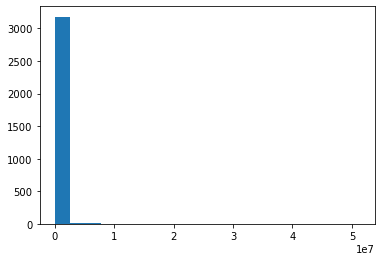

In [24]:
plt.hist(byte_entropy['byteentropy_0'], bins = 20)

In [25]:
byte_entropy['byteentropy_0'].shape

(3204,)

In [26]:
byte_entropy.iloc[:,0]

0           0
1       47100
2        6144
3           0
4           0
        ...  
3991        0
3995        0
3997        0
3998        0
3999     8127
Name: byteentropy_0, Length: 3204, dtype: int64

# Histograms for all columns

C:\Users\Marcin\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


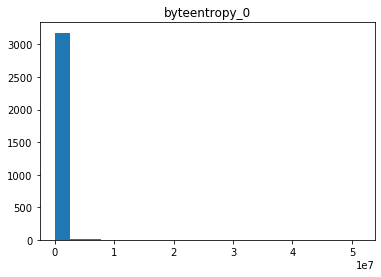

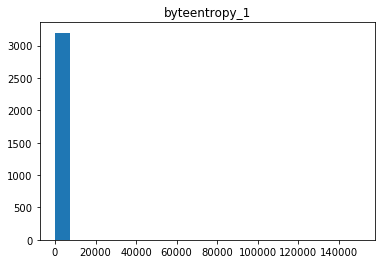

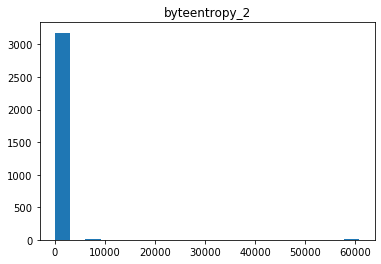

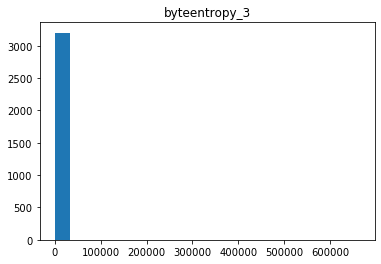

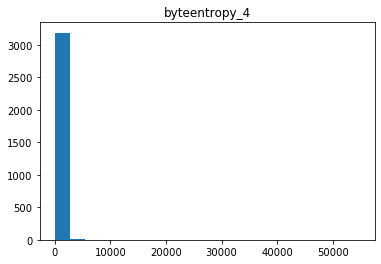

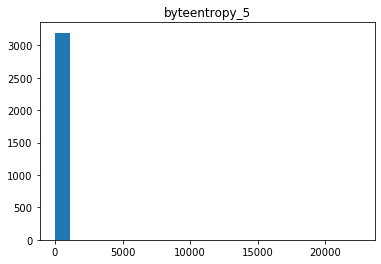

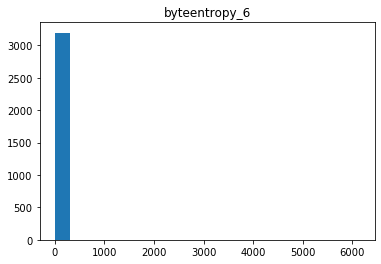

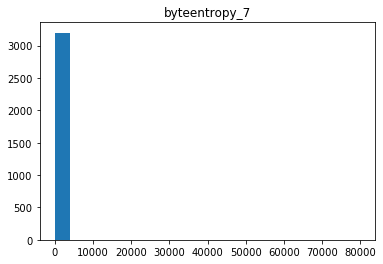

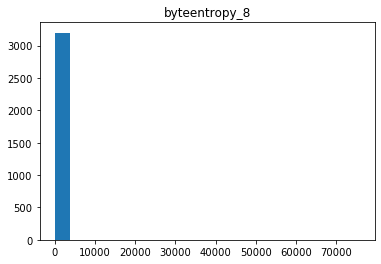

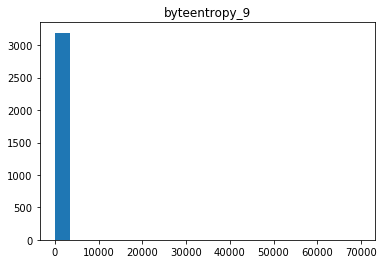

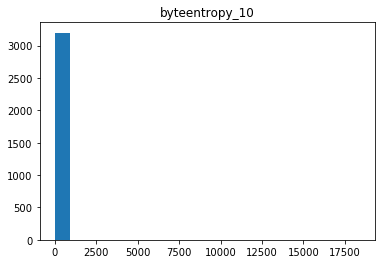

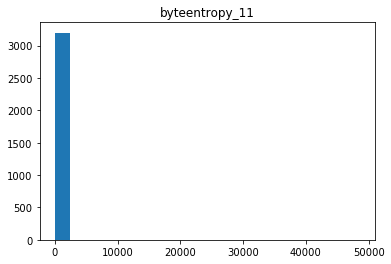

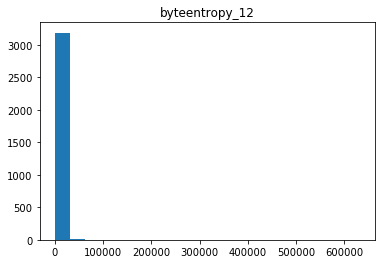

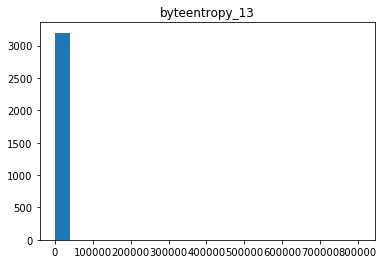

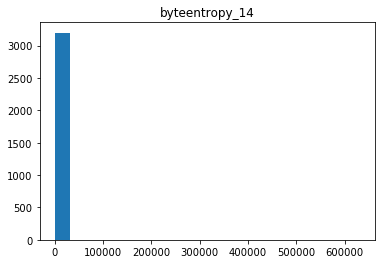

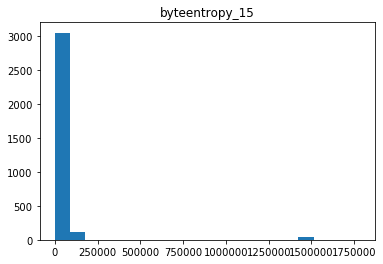

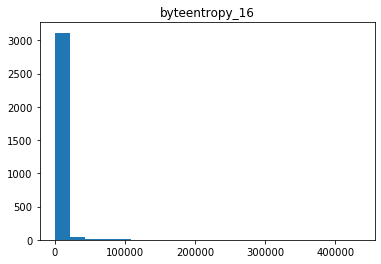

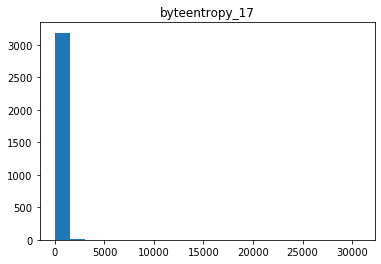

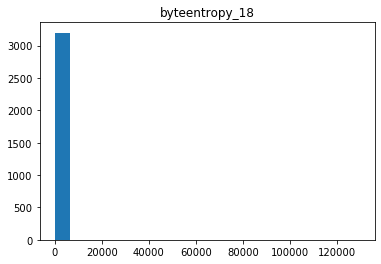

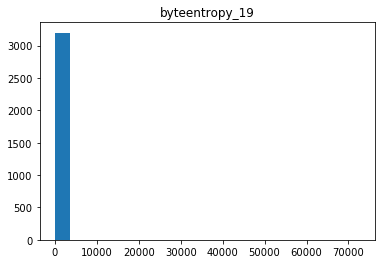

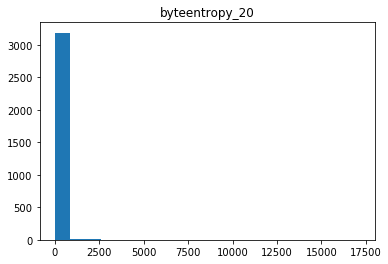

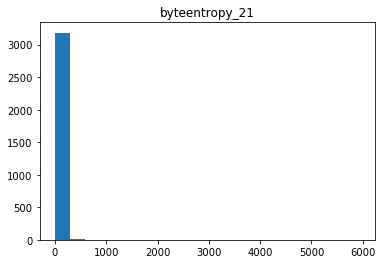

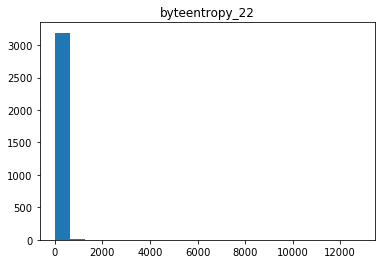

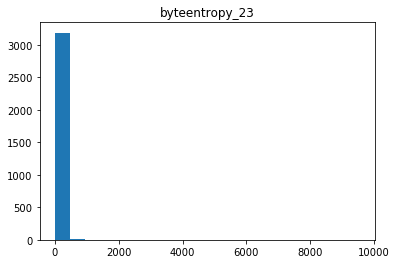

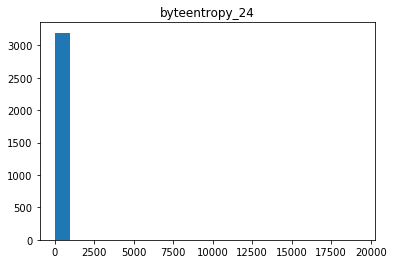

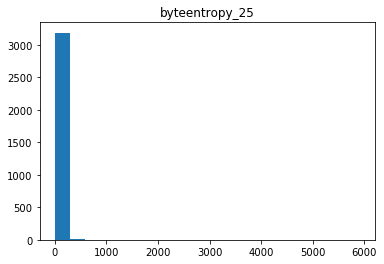

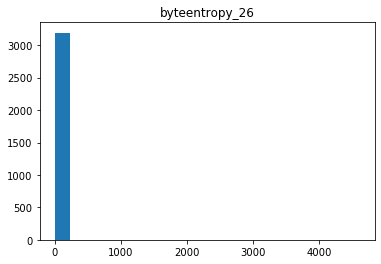

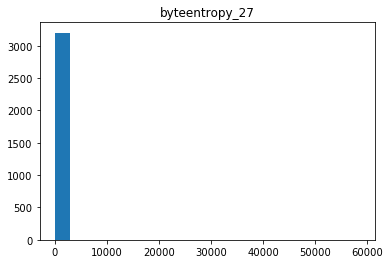

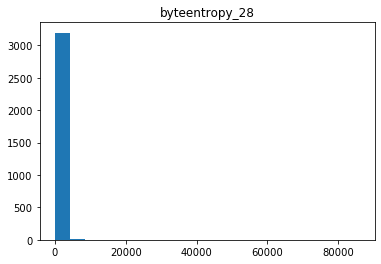

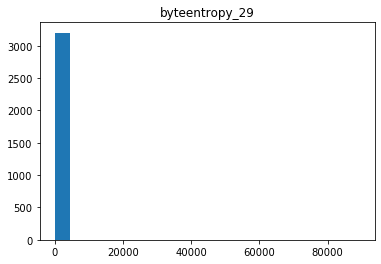

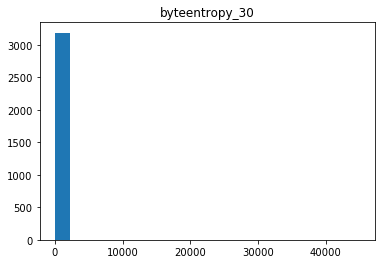

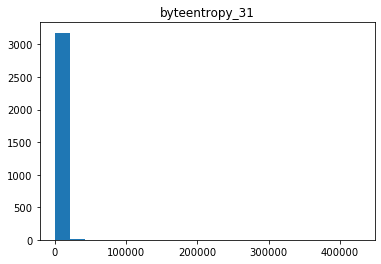

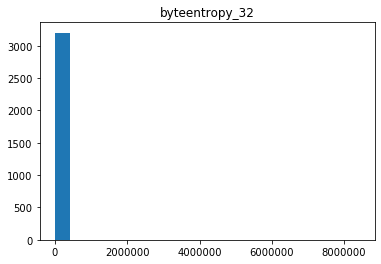

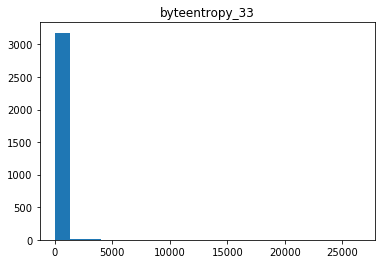

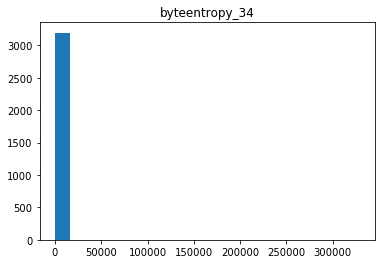

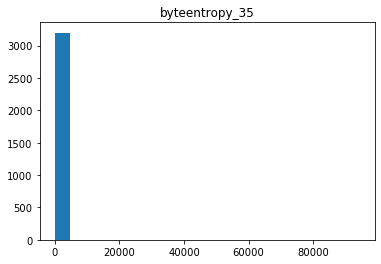

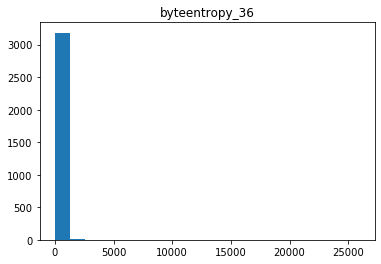

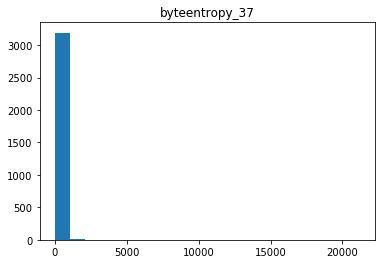

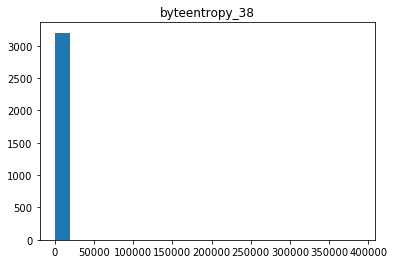

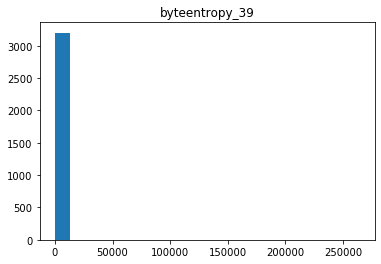

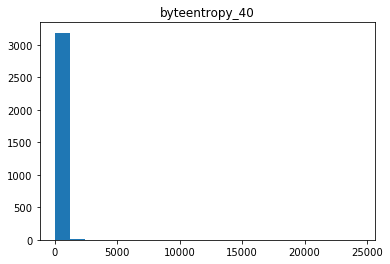

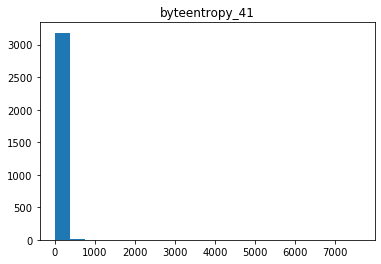

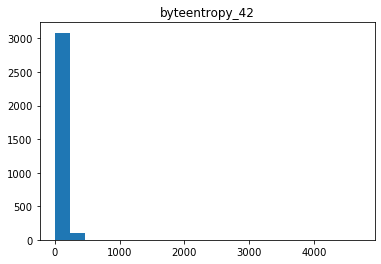

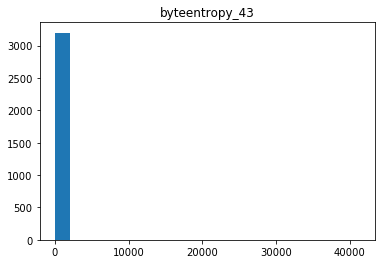

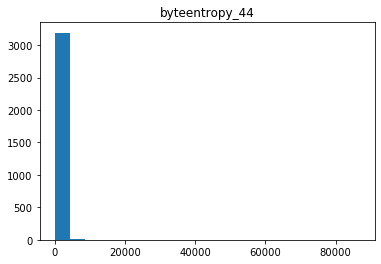

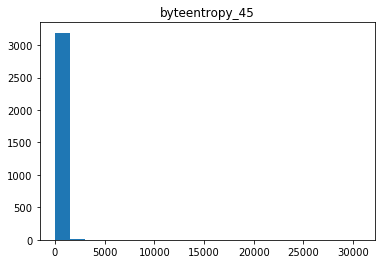

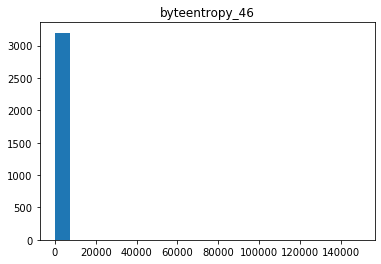

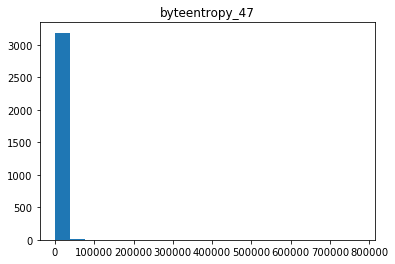

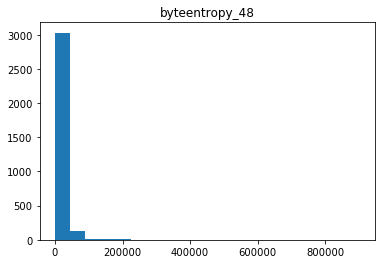

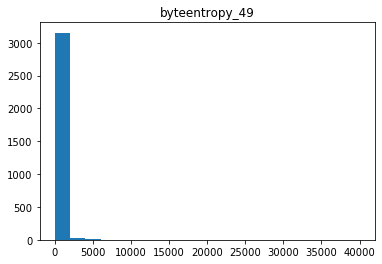

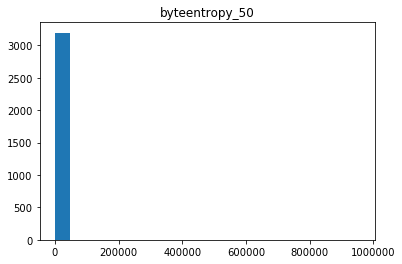

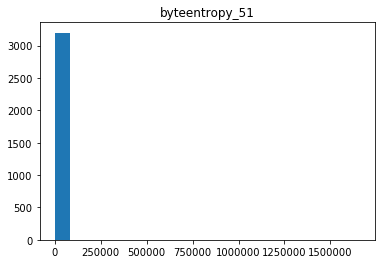

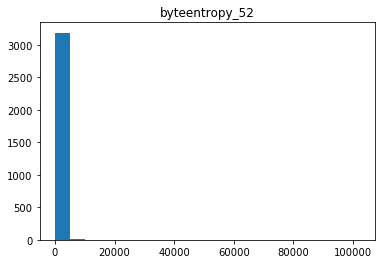

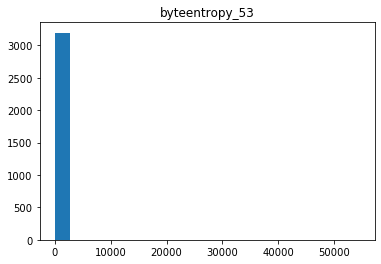

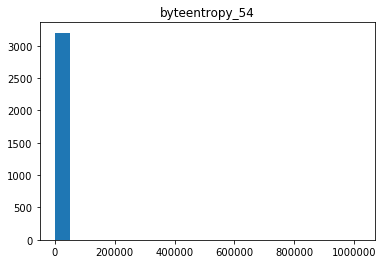

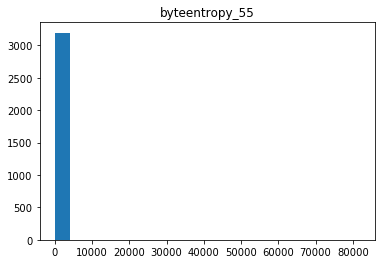

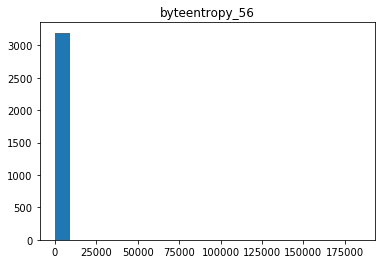

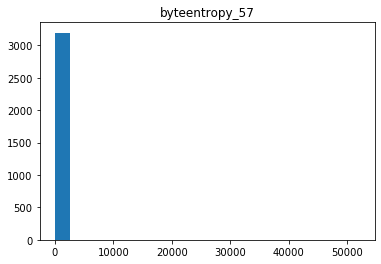

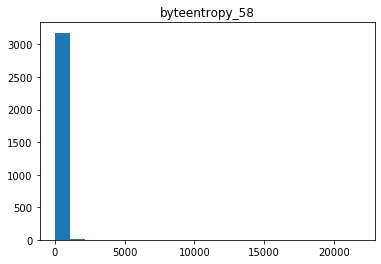

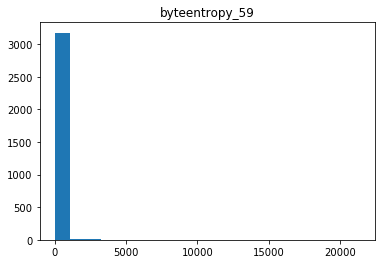

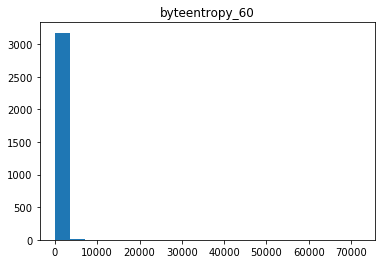

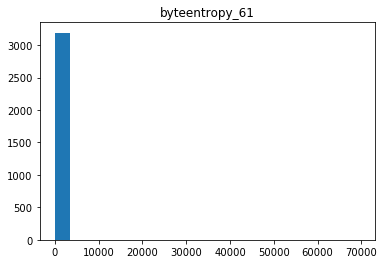

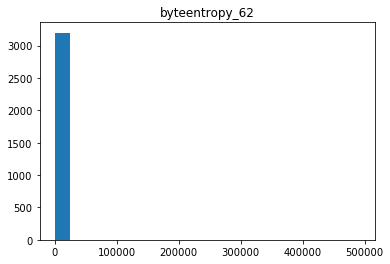

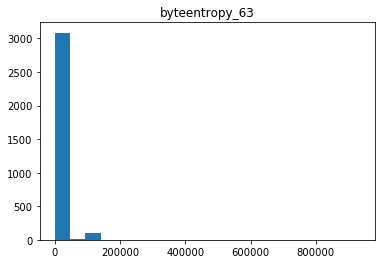

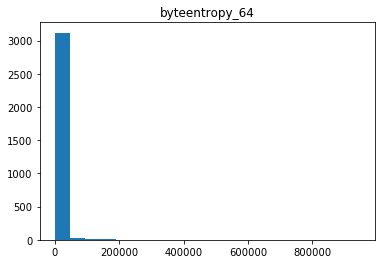

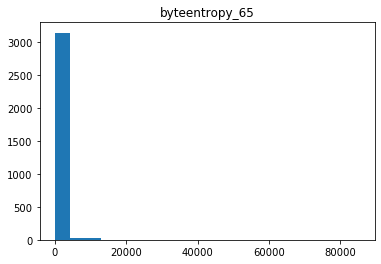

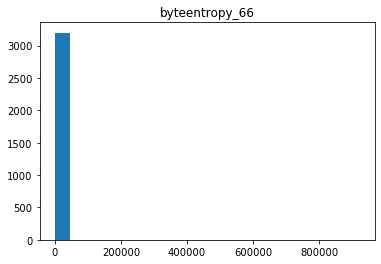

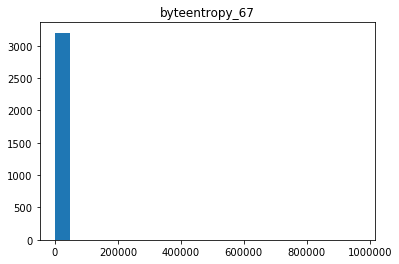

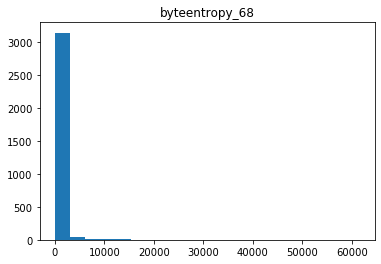

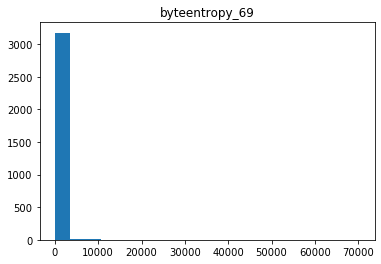

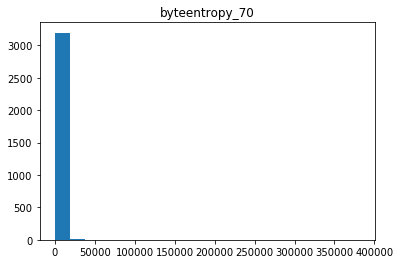

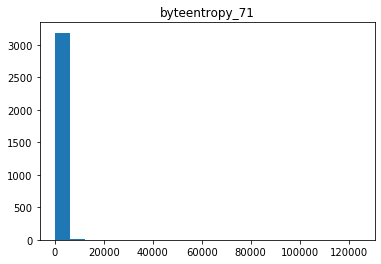

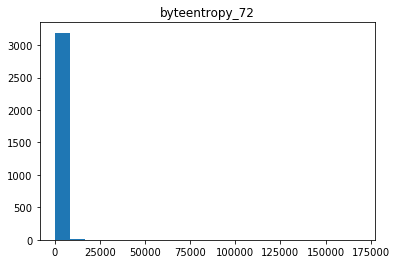

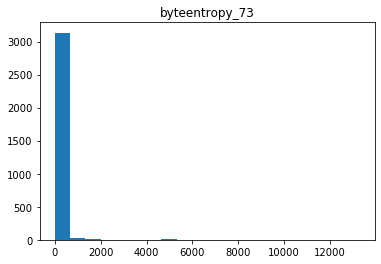

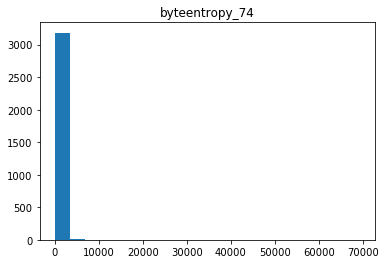

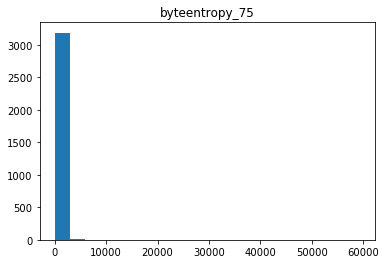

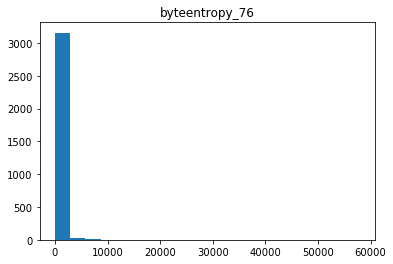

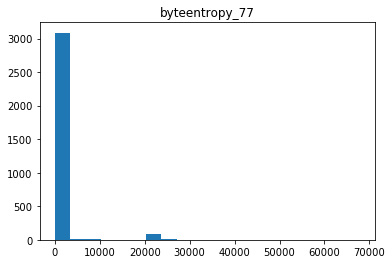

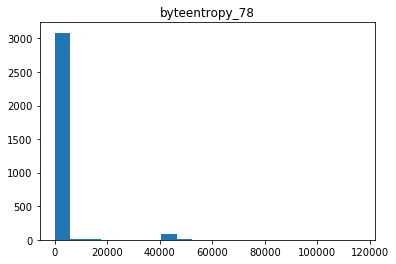

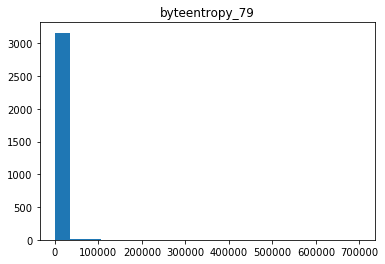

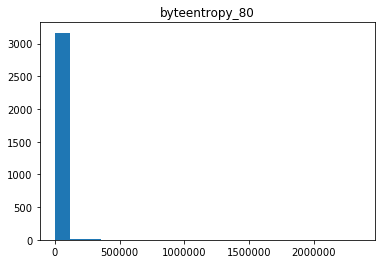

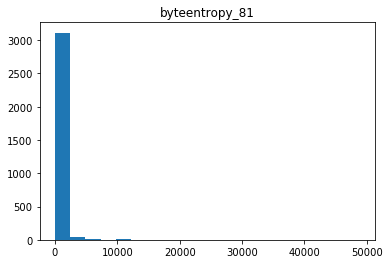

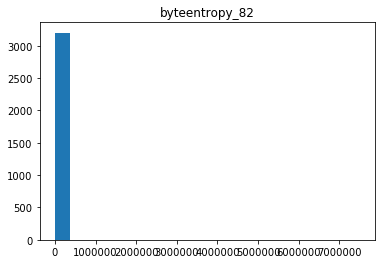

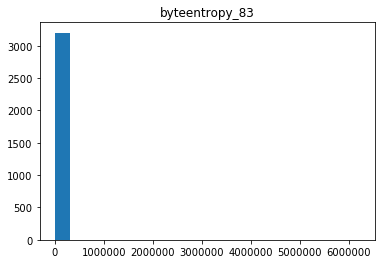

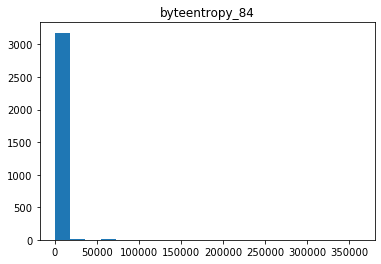

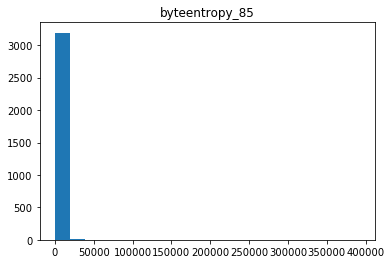

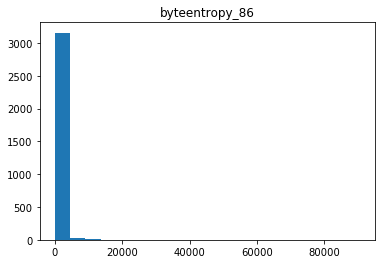

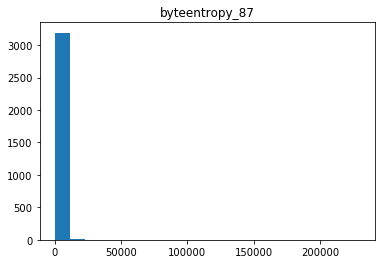

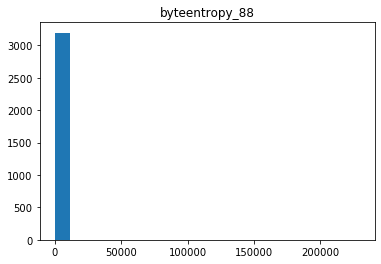

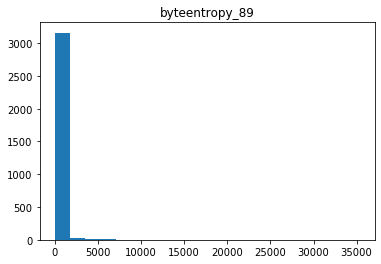

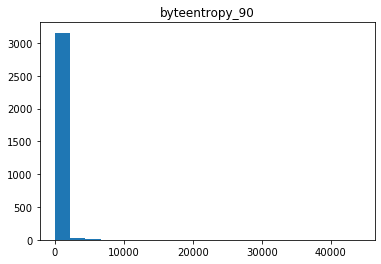

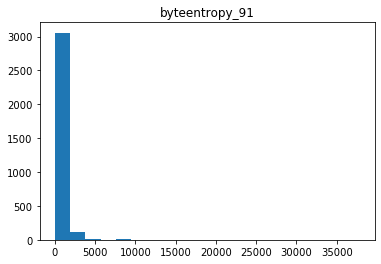

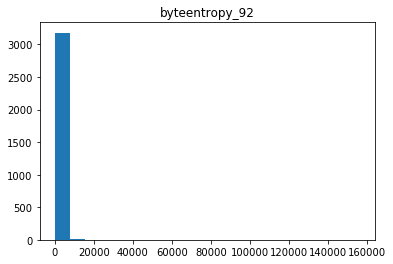

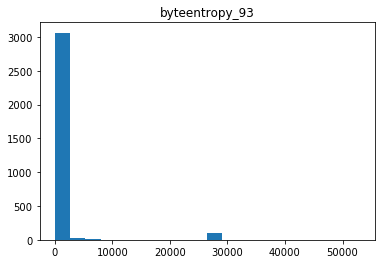

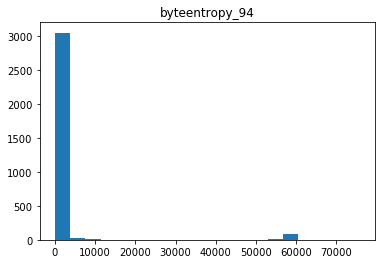

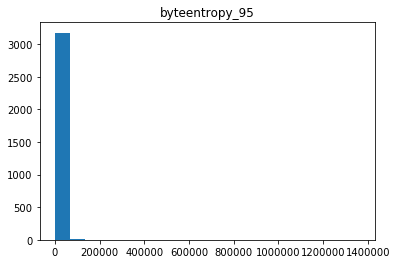

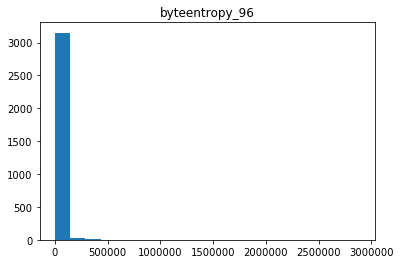

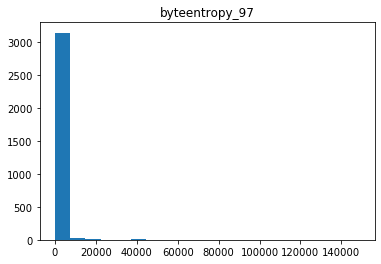

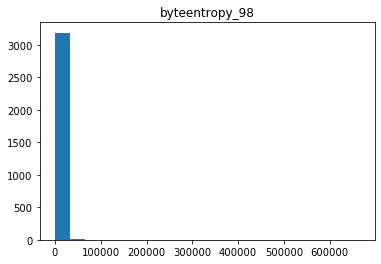

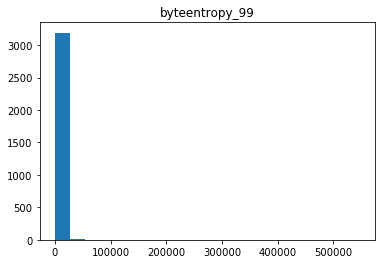

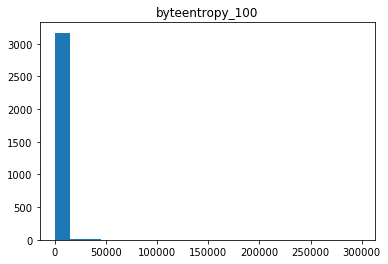

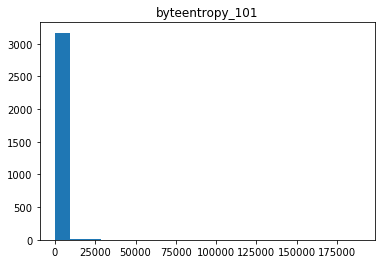

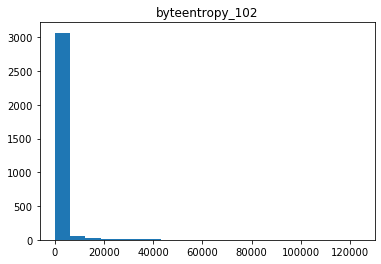

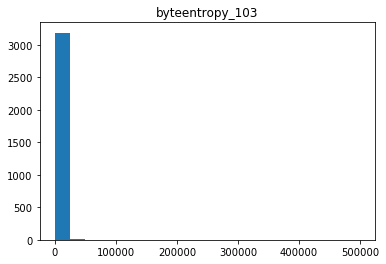

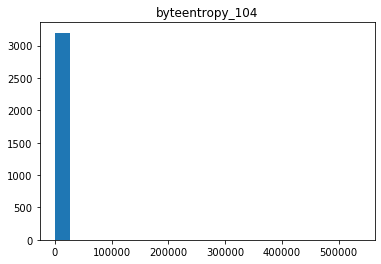

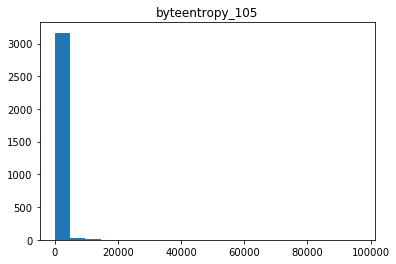

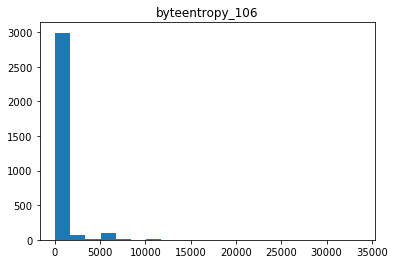

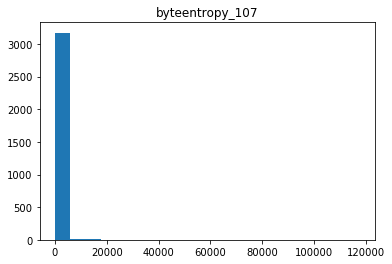

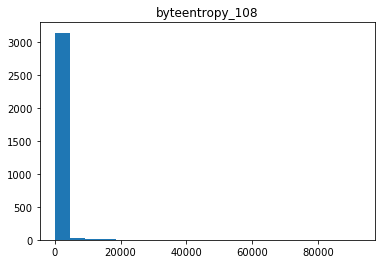

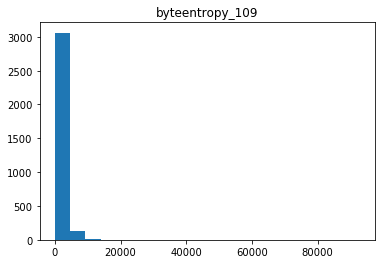

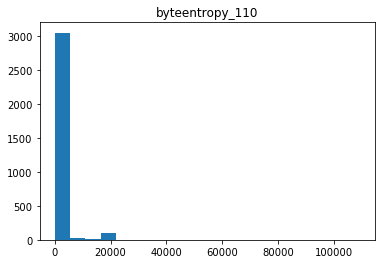

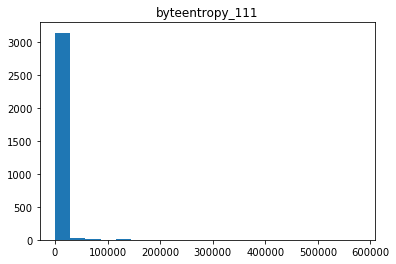

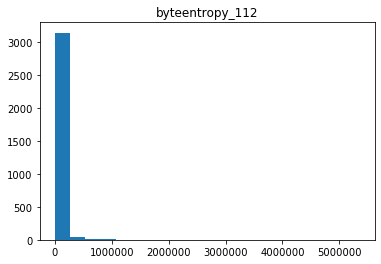

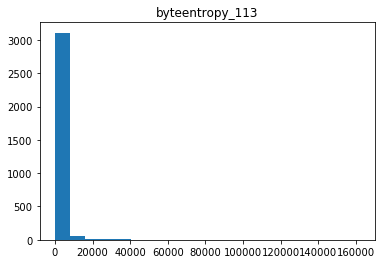

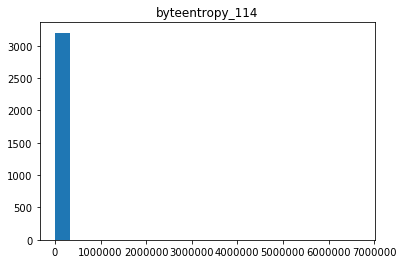

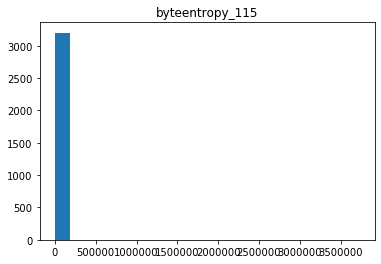

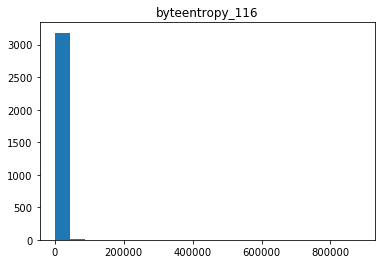

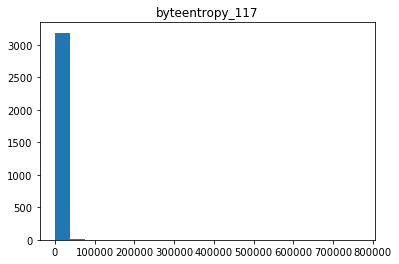

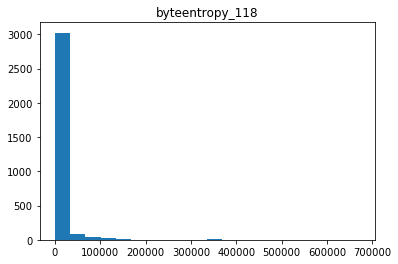

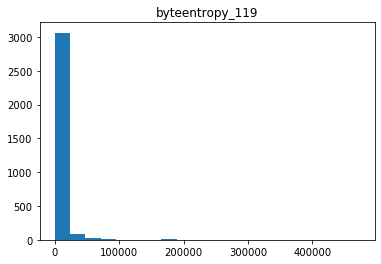

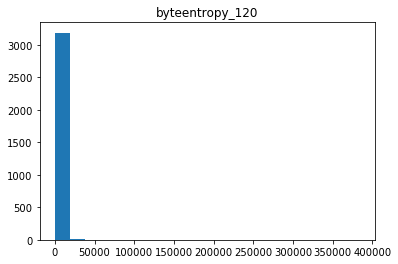

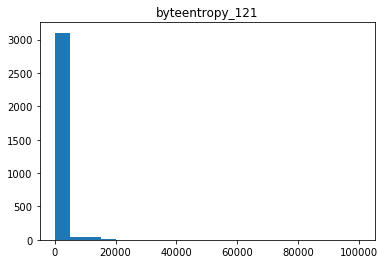

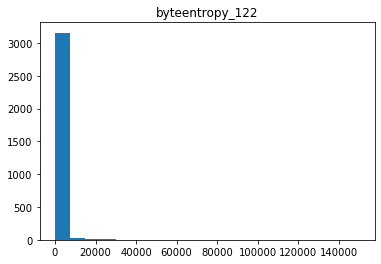

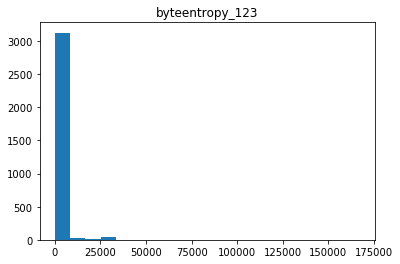

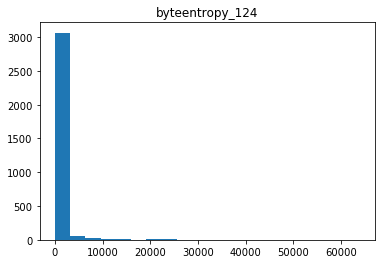

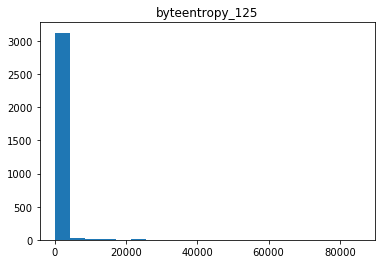

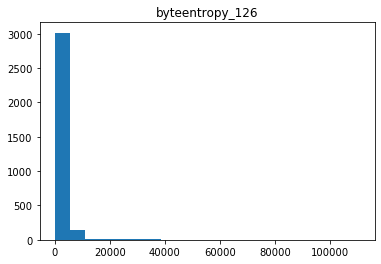

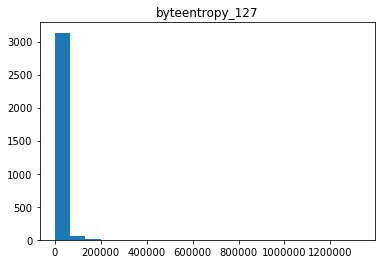

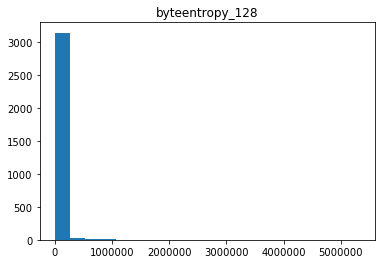

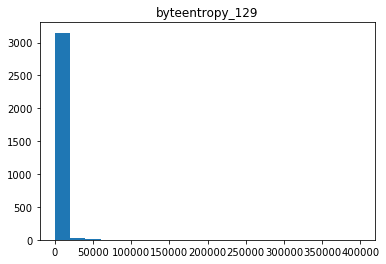

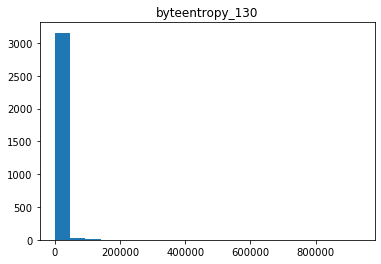

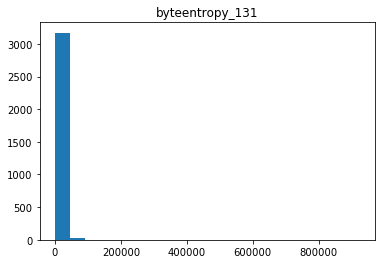

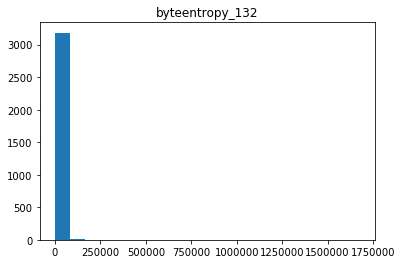

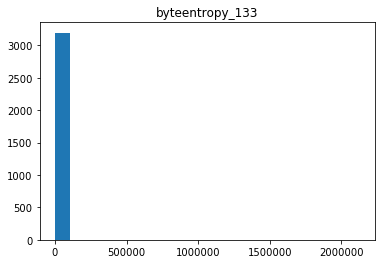

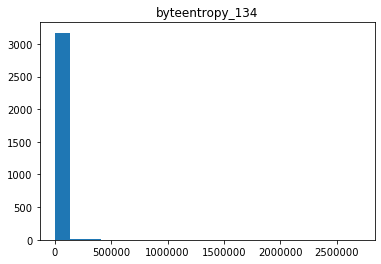

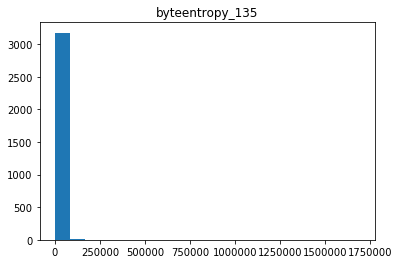

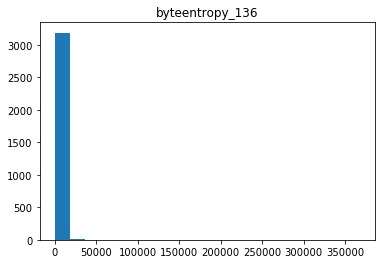

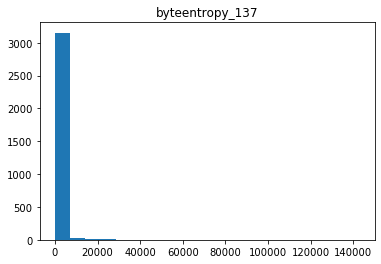

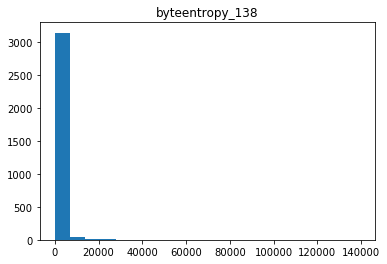

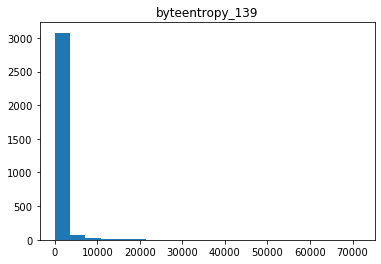

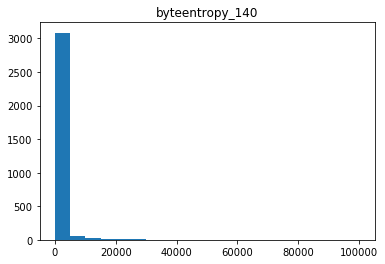

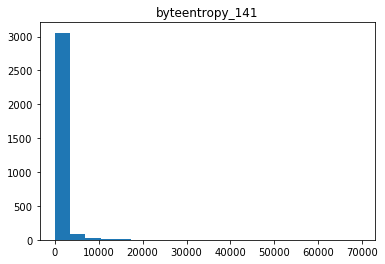

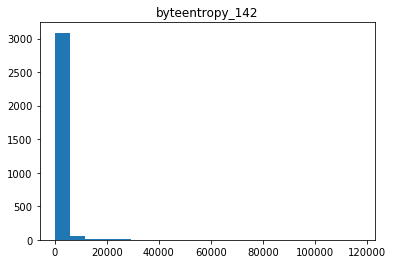

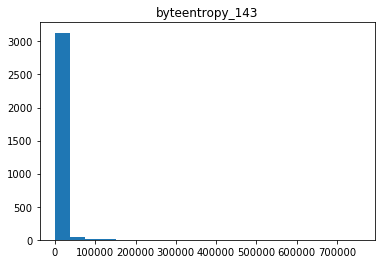

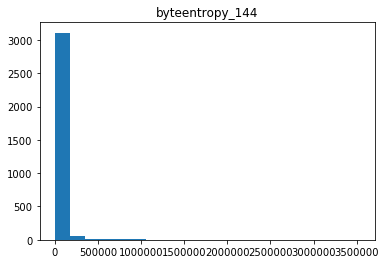

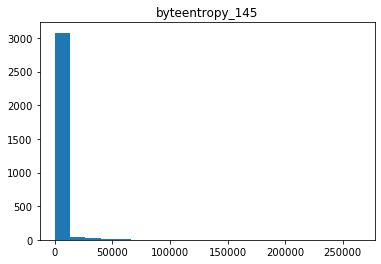

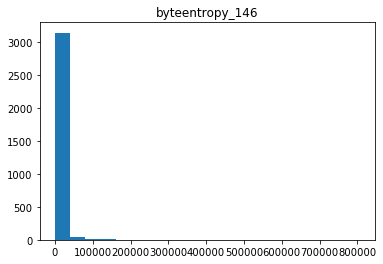

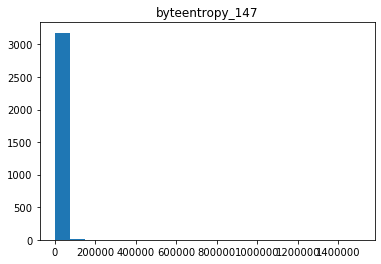

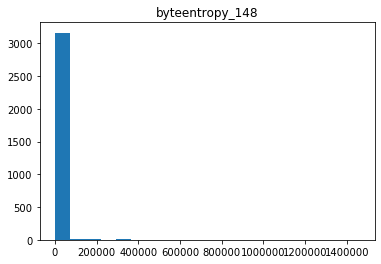

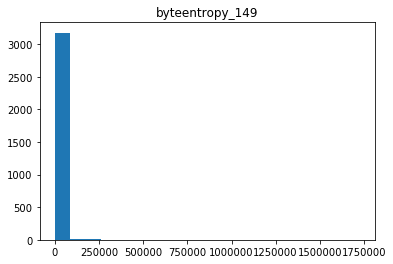

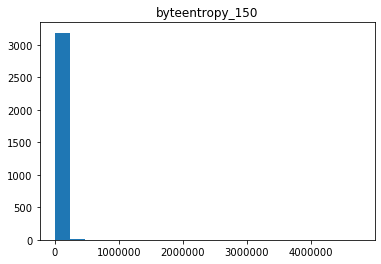

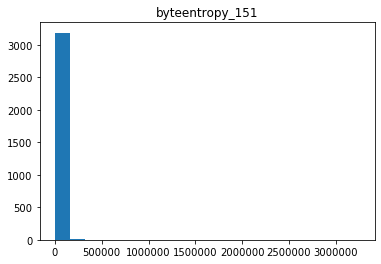

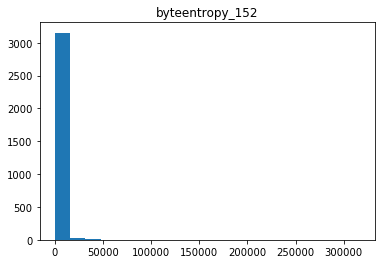

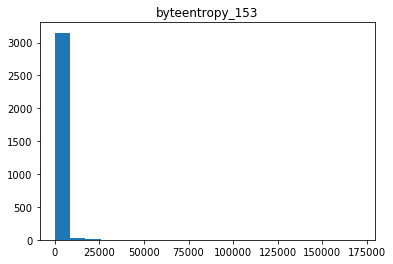

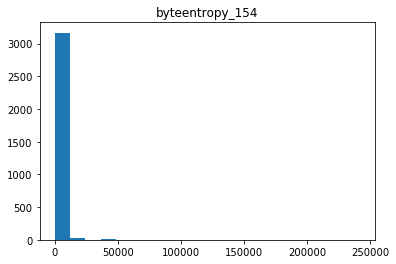

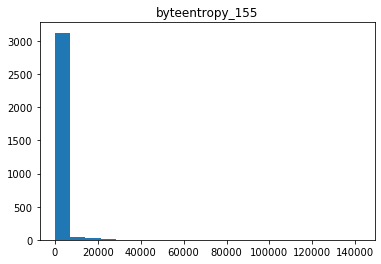

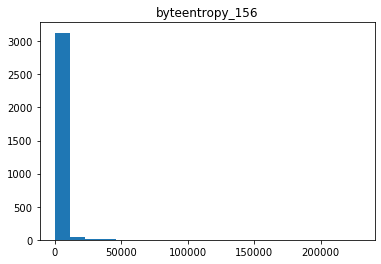

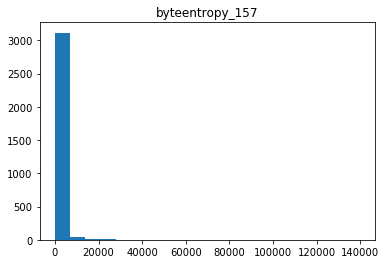

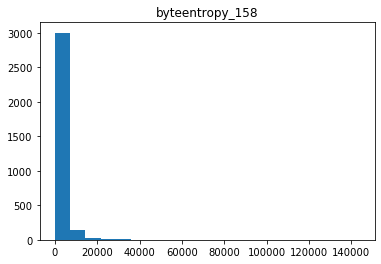

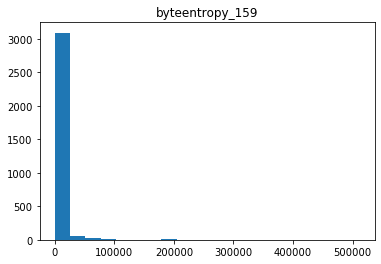

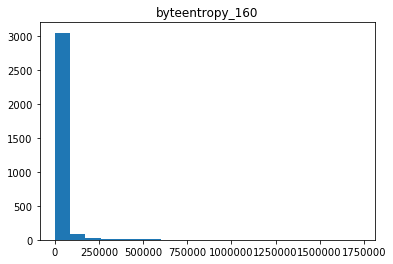

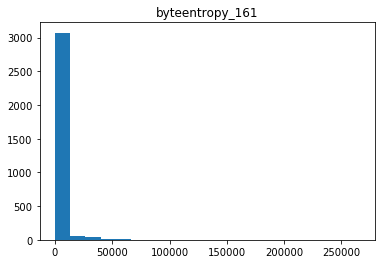

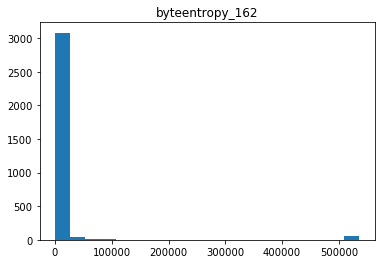

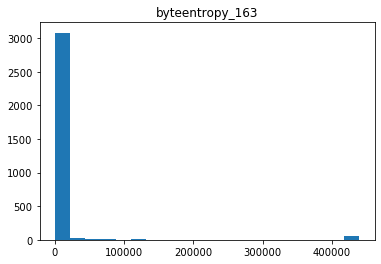

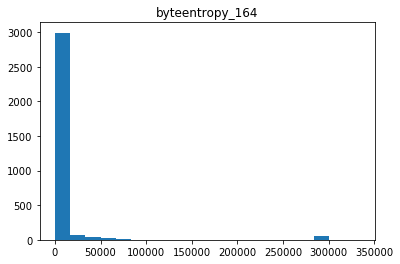

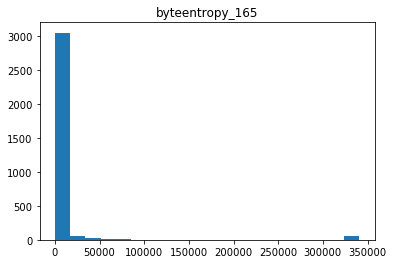

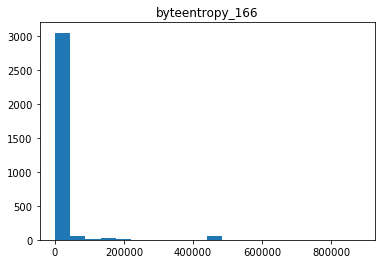

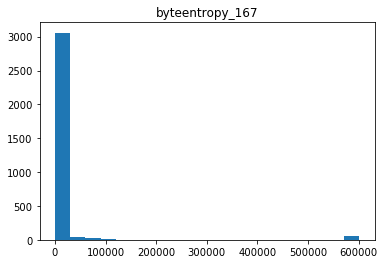

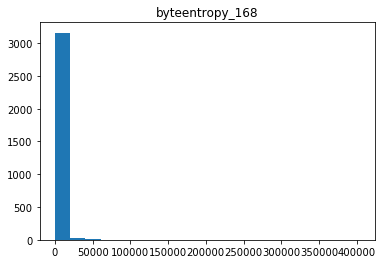

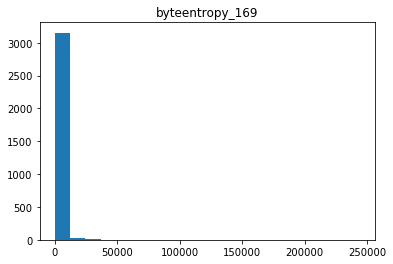

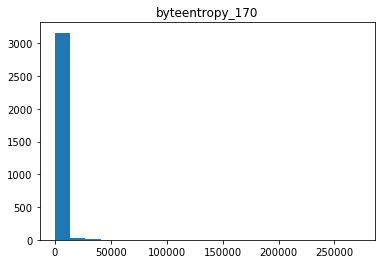

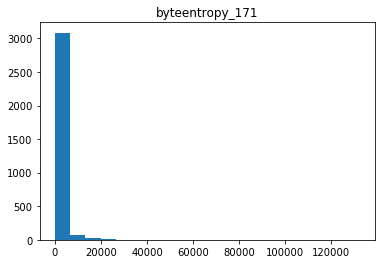

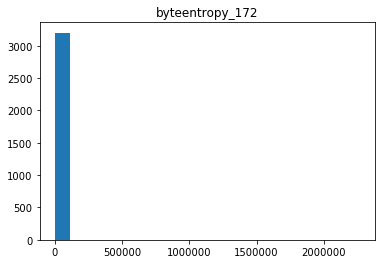

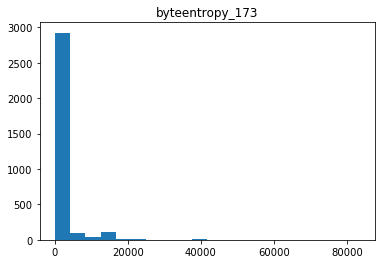

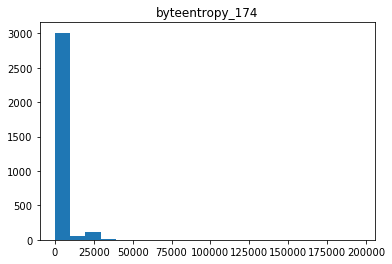

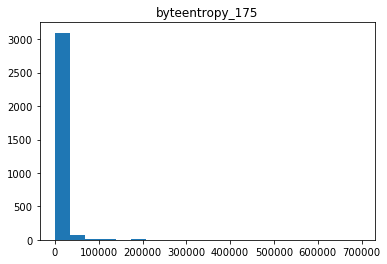

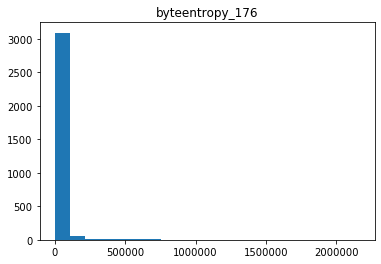

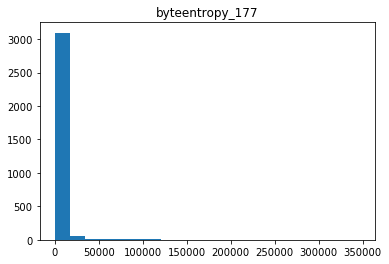

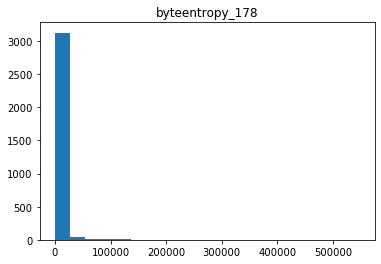

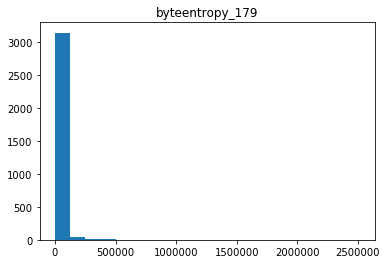

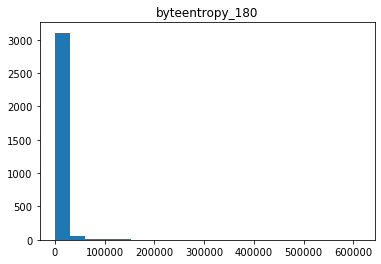

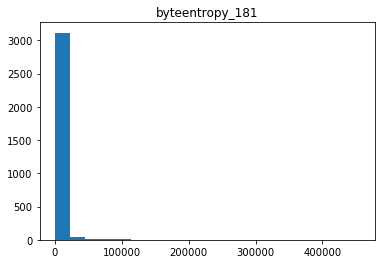

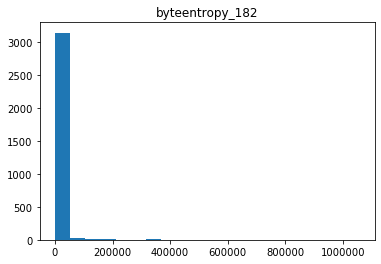

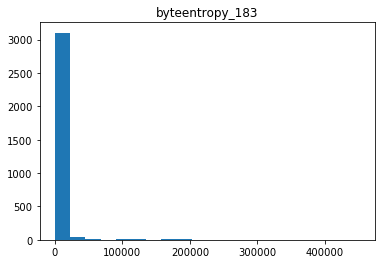

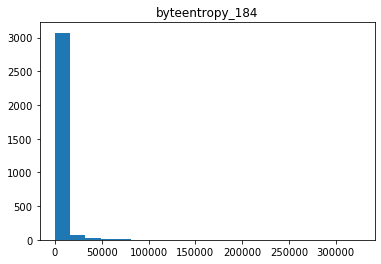

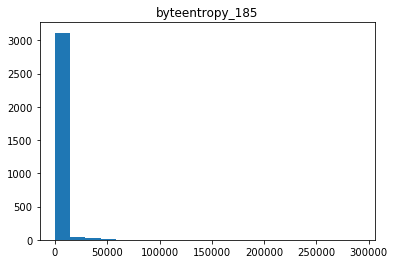

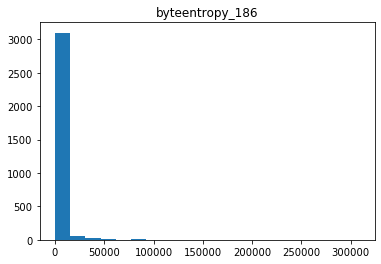

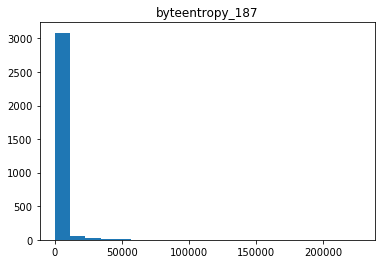

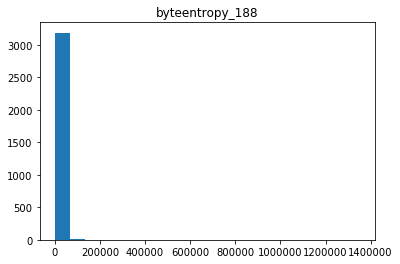

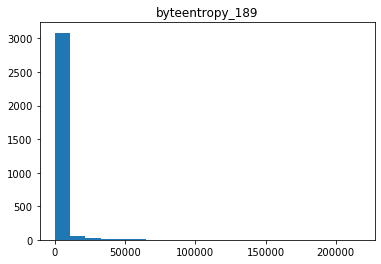

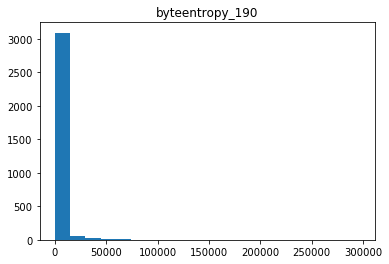

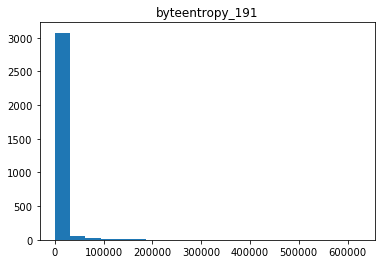

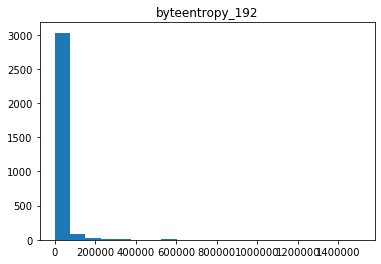

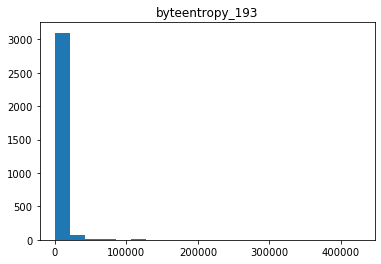

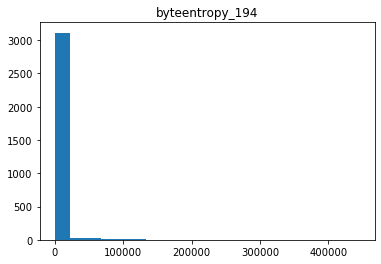

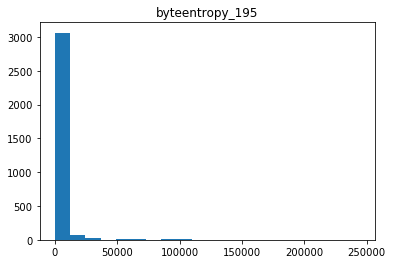

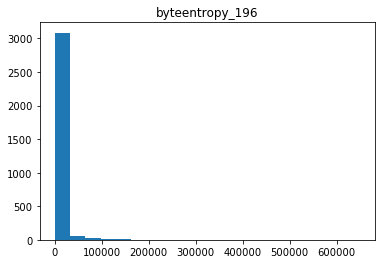

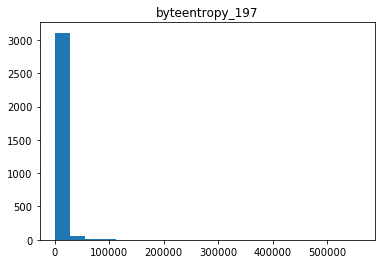

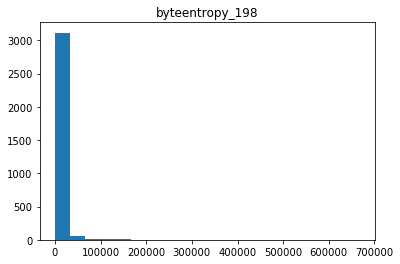

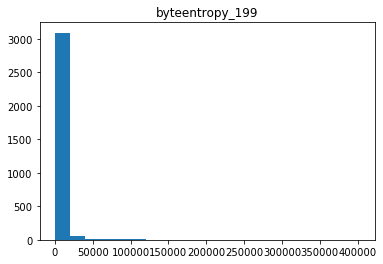

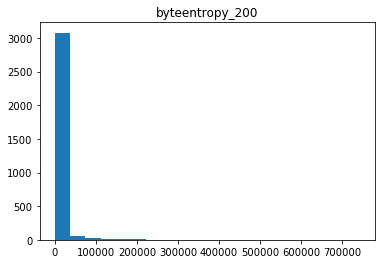

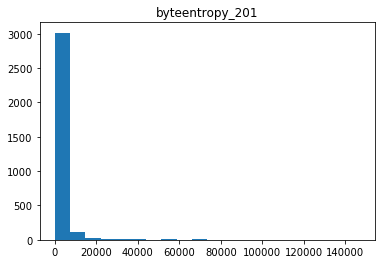

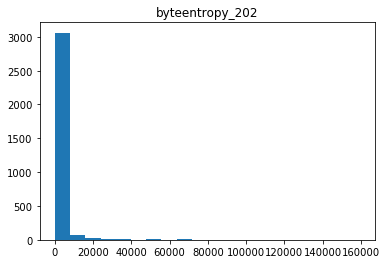

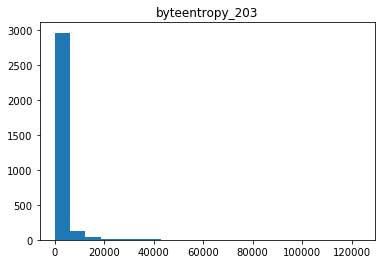

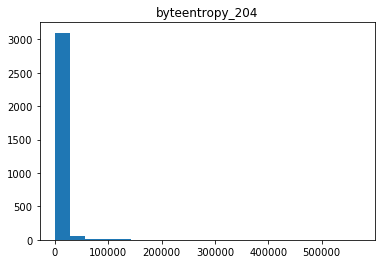

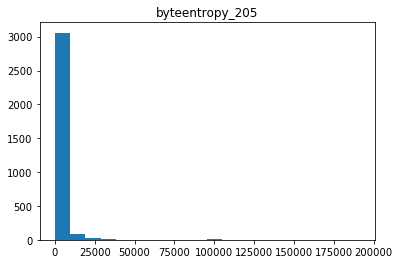

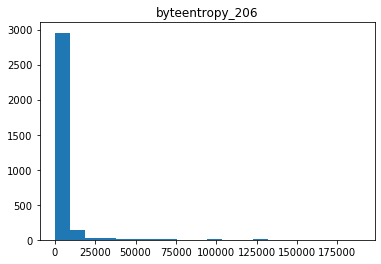

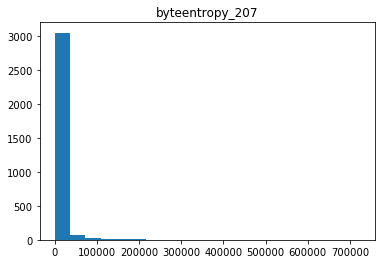

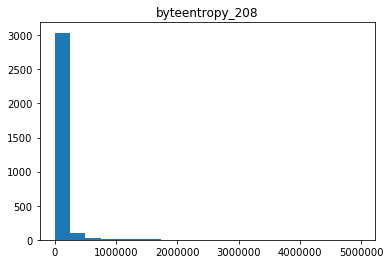

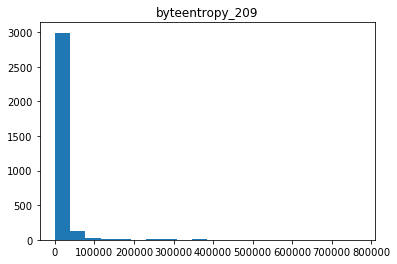

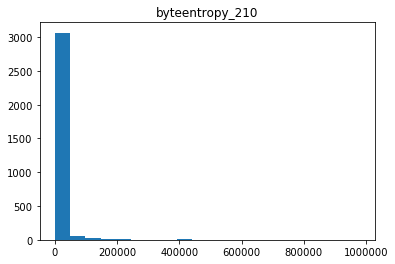

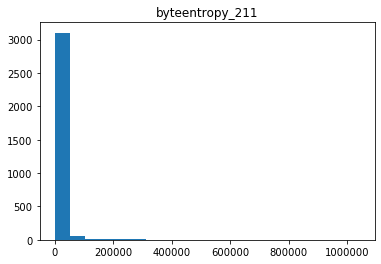

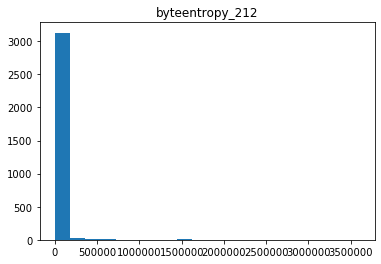

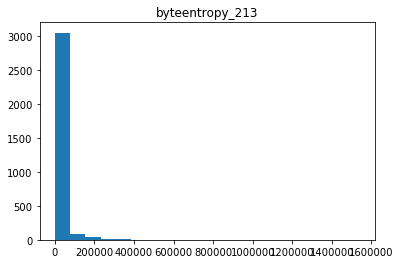

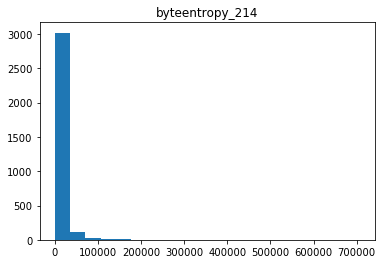

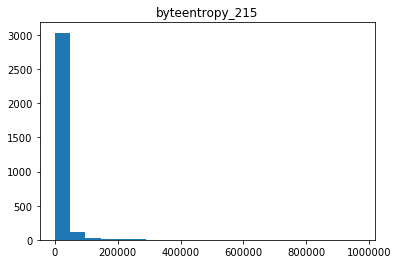

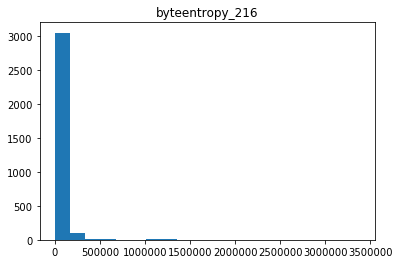

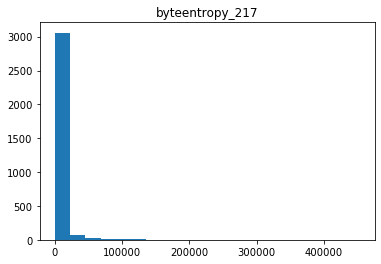

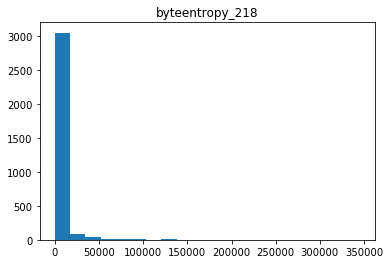

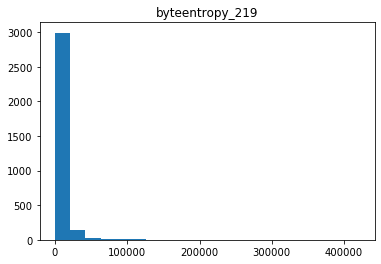

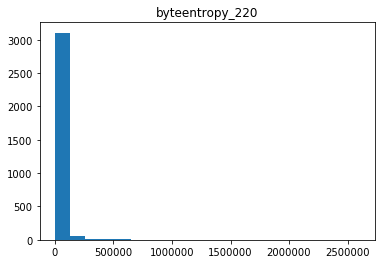

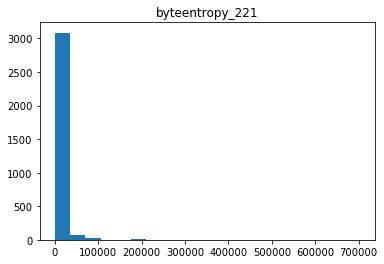

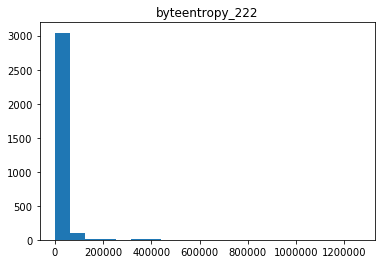

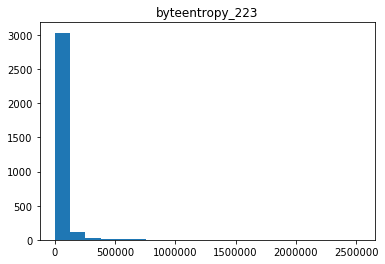

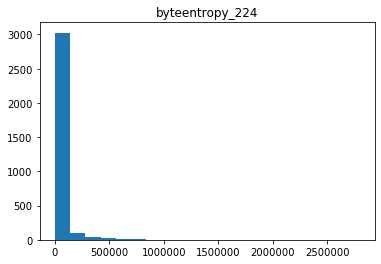

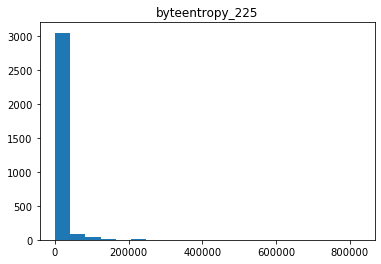

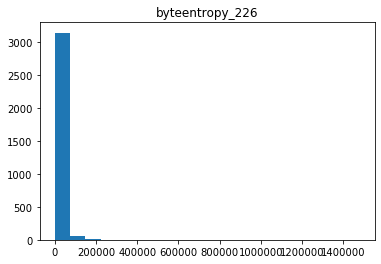

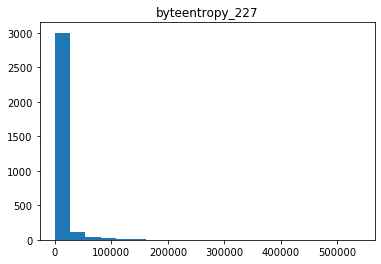

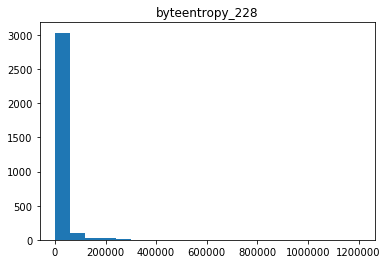

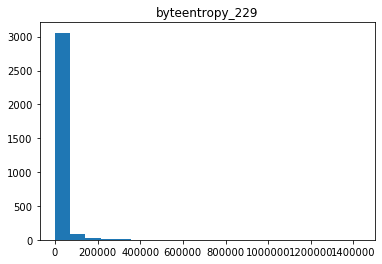

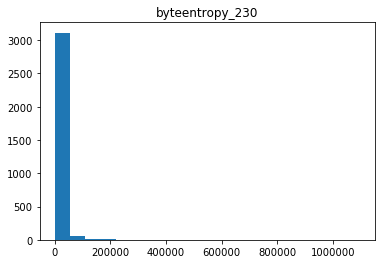

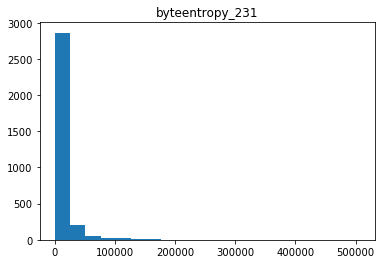

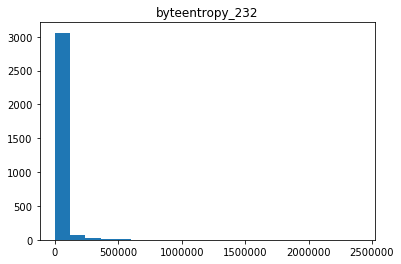

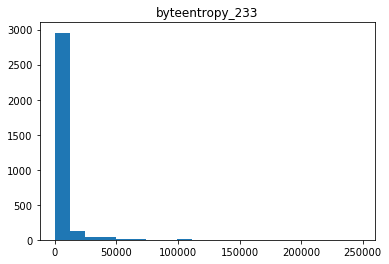

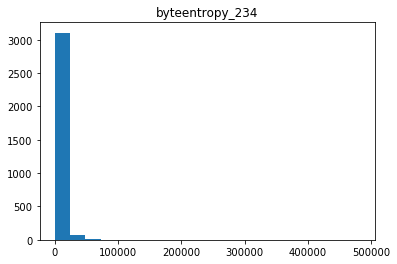

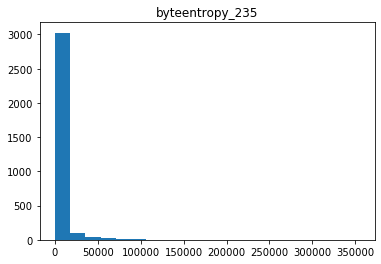

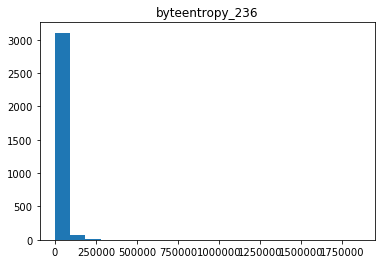

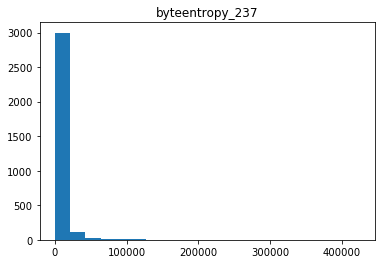

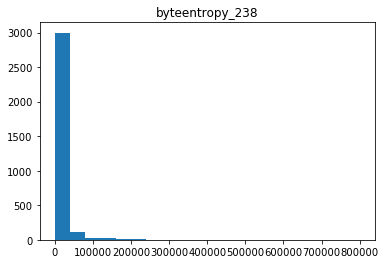

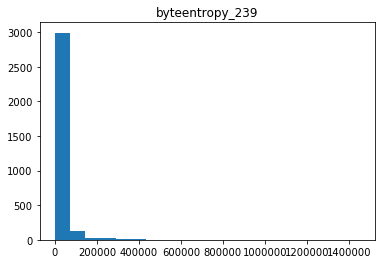

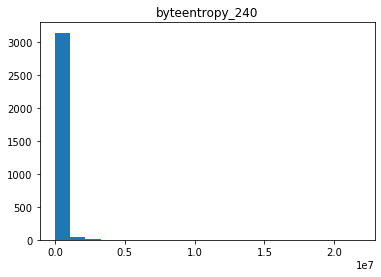

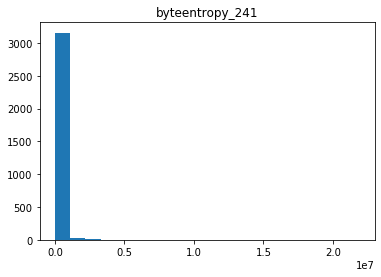

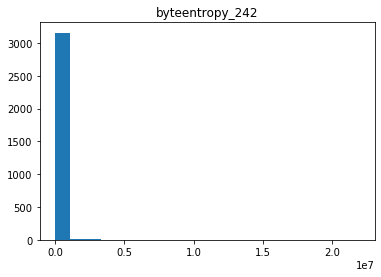

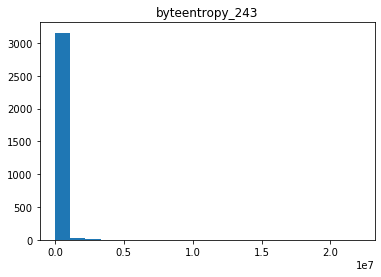

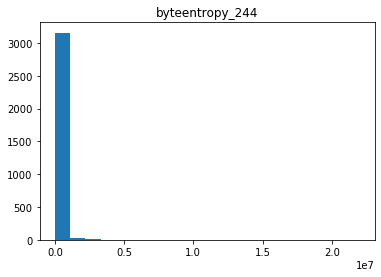

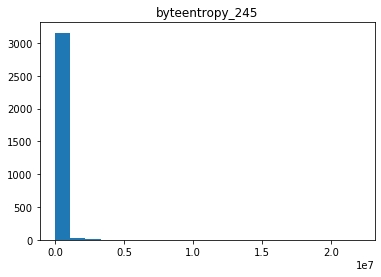

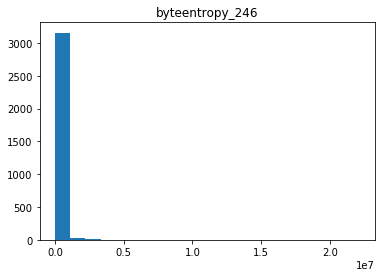

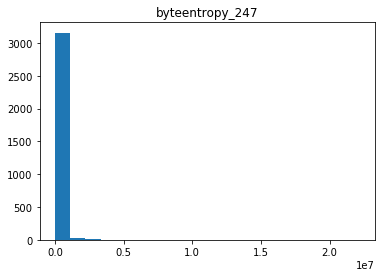

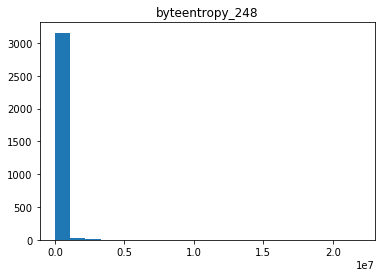

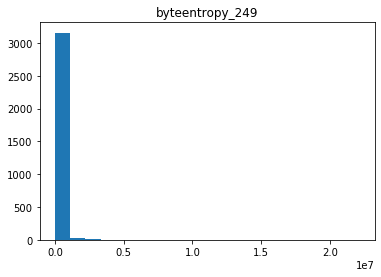

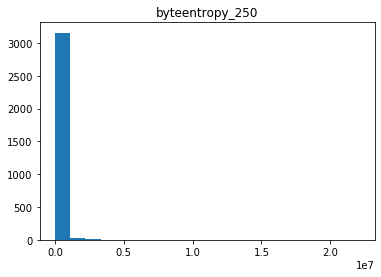

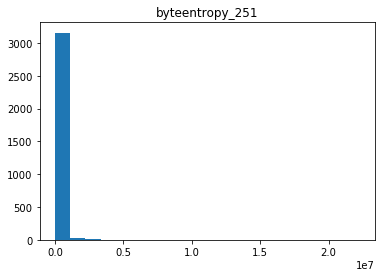

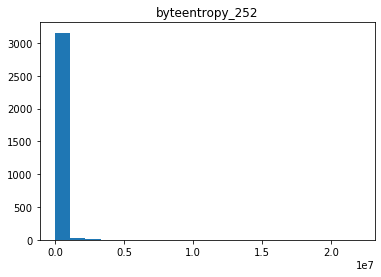

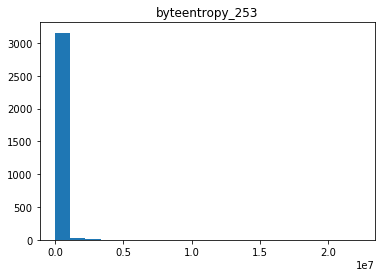

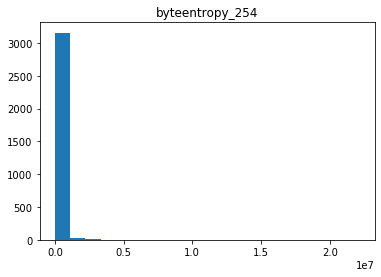

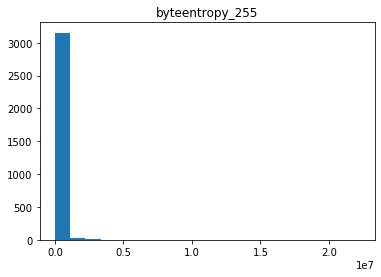

In [27]:
for i in range(256):
    plt.figure()
    plt.title("byteentropy_" + str(i))
    plt.hist(byte_entropy.iloc[:,i], bins=20)

In [28]:
#for sample in byte_entropy:
#    plt.figure()
#    #plt.title(sample) 
#    plt.ylabel('number of records') 
#    plt.hist(byte_entropy[sample], bins=20)

# Histograms for first 100 records

C:\Users\Marcin\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


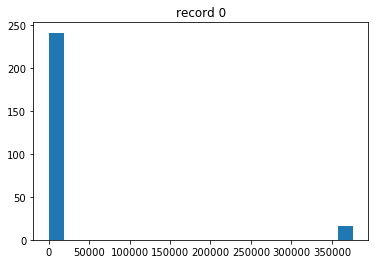

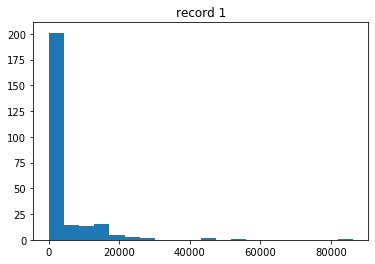

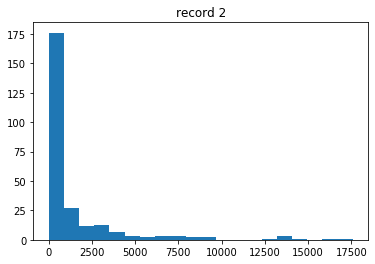

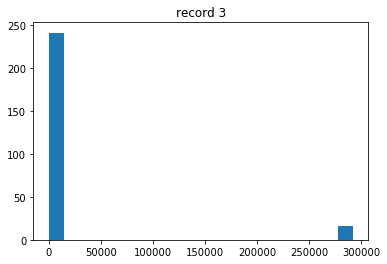

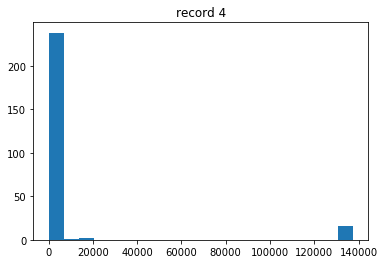

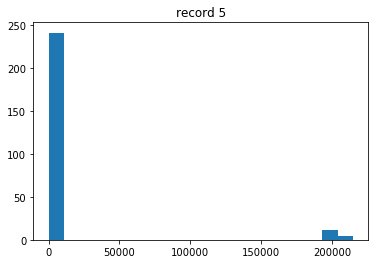

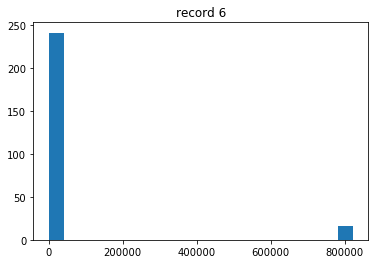

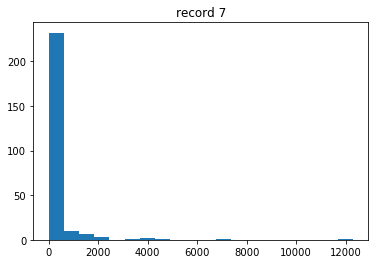

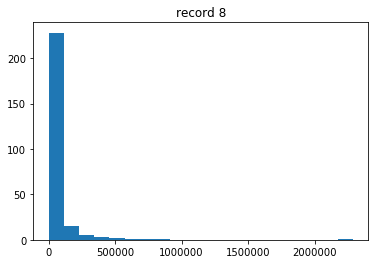

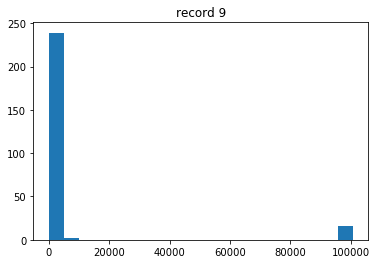

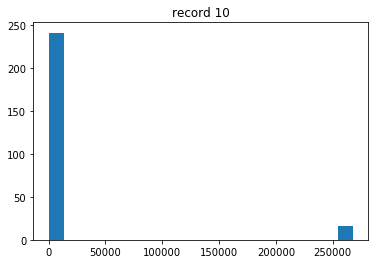

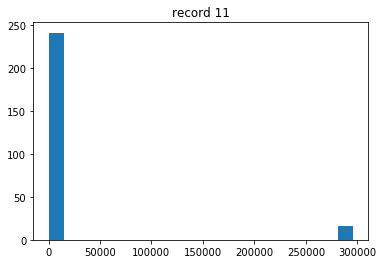

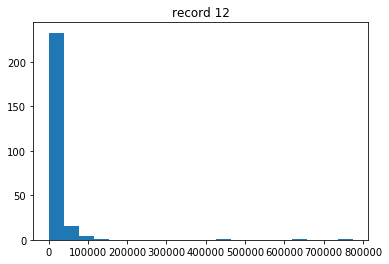

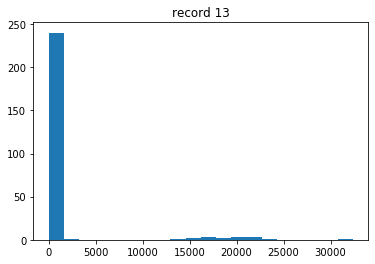

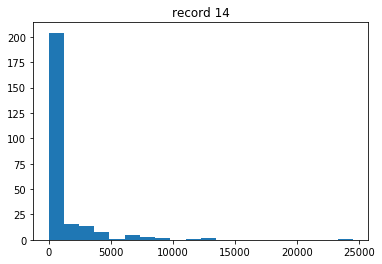

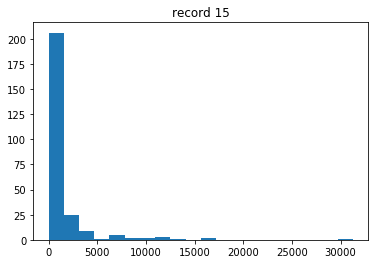

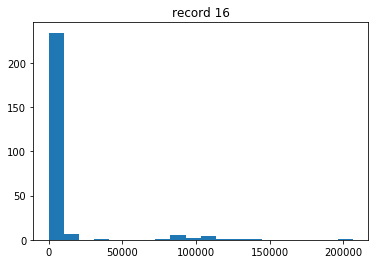

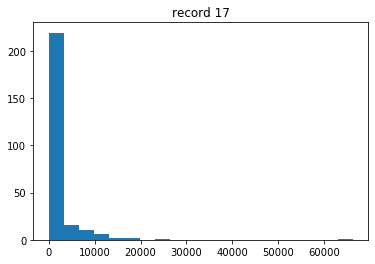

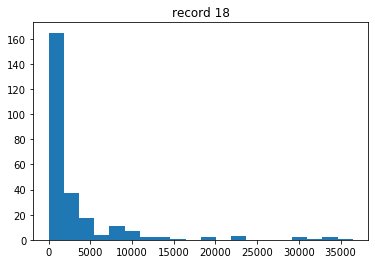

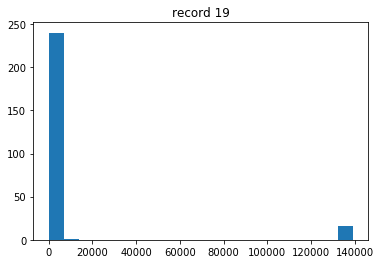

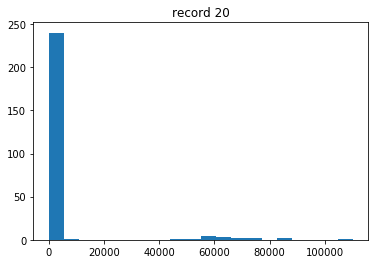

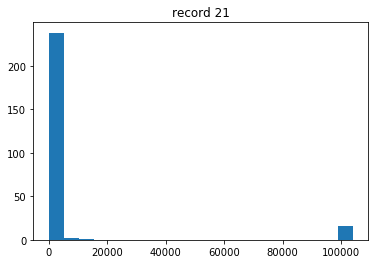

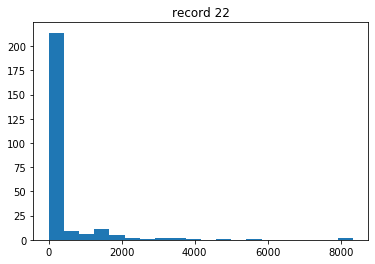

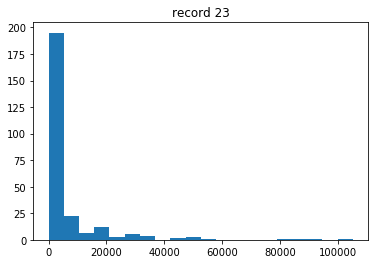

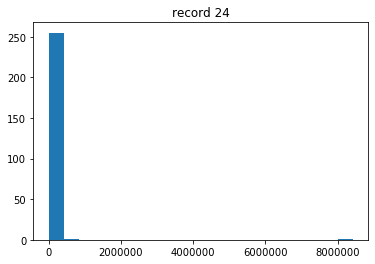

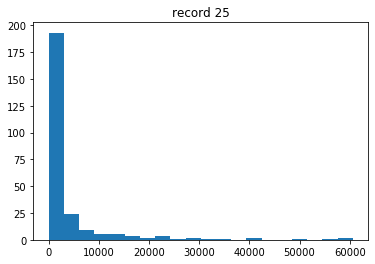

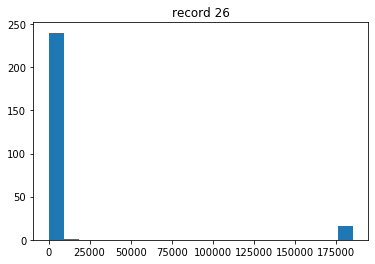

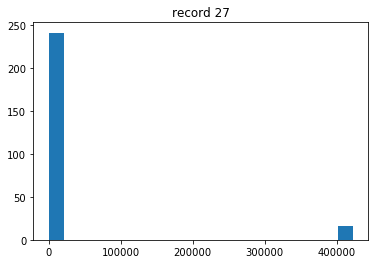

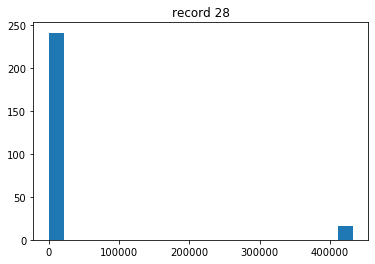

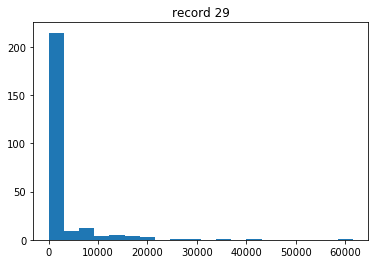

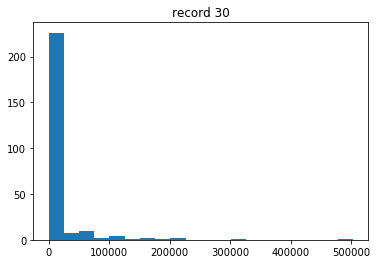

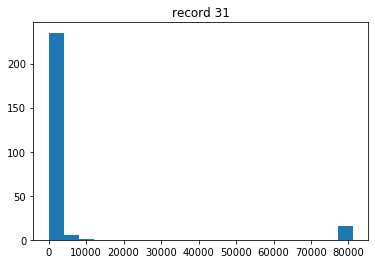

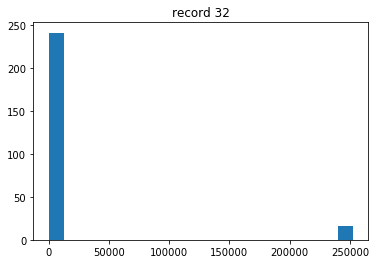

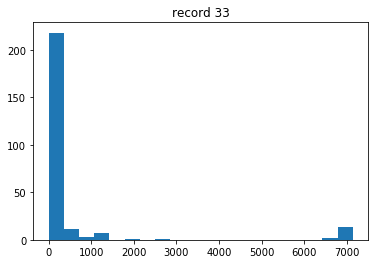

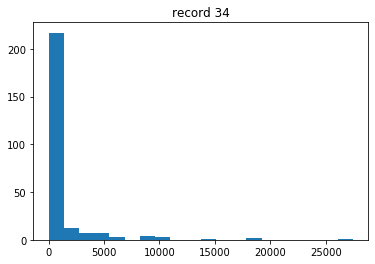

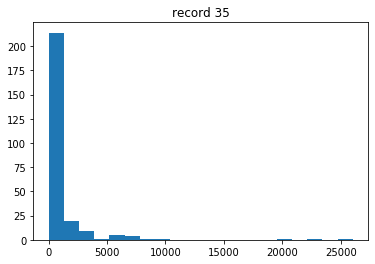

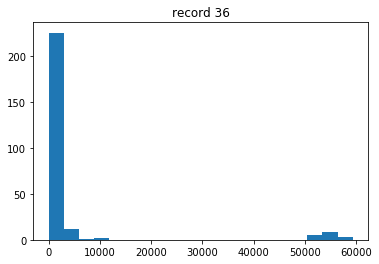

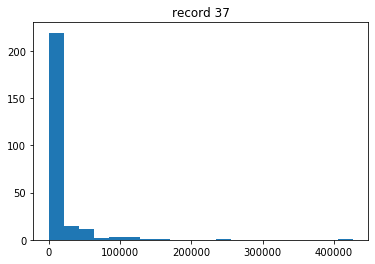

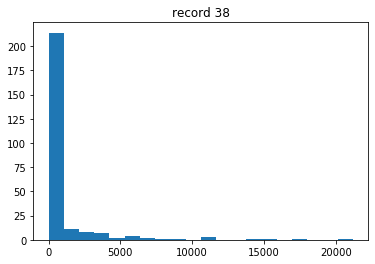

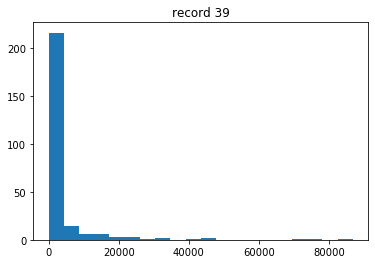

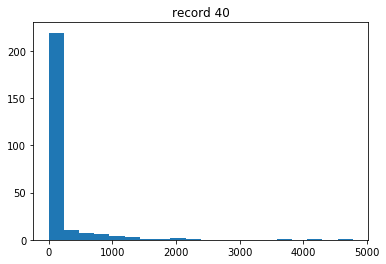

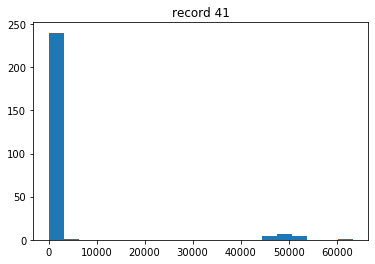

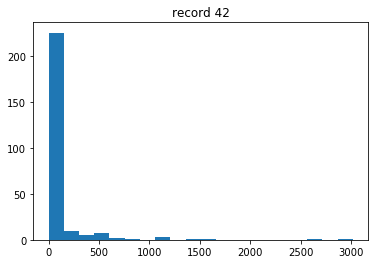

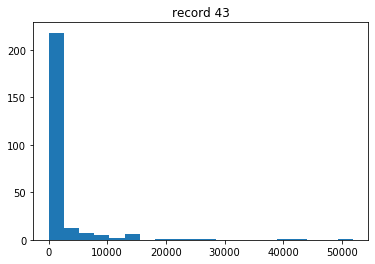

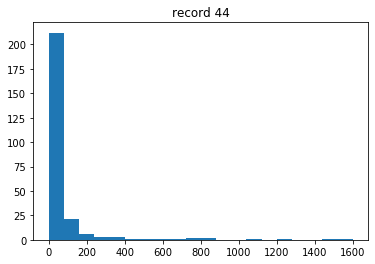

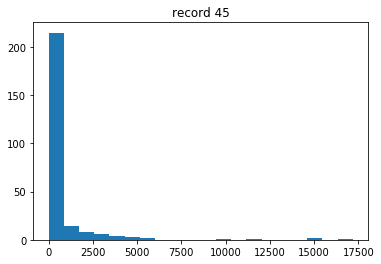

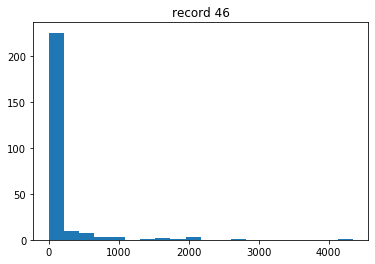

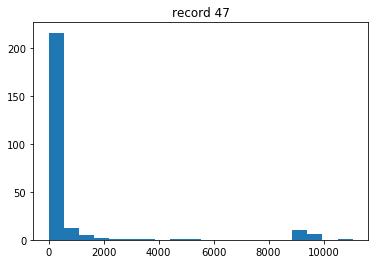

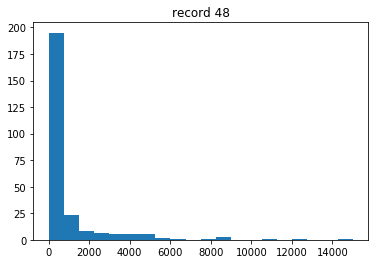

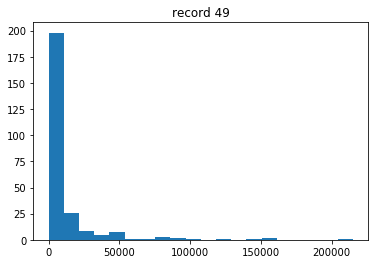

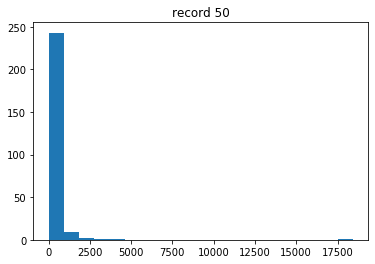

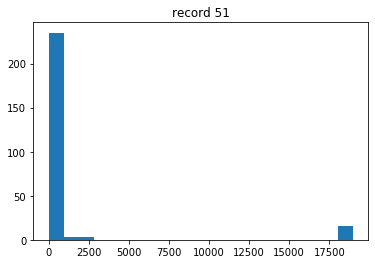

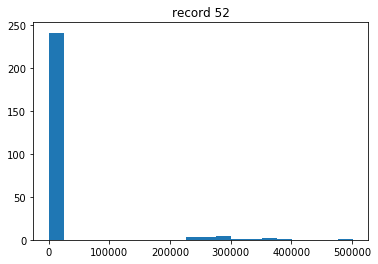

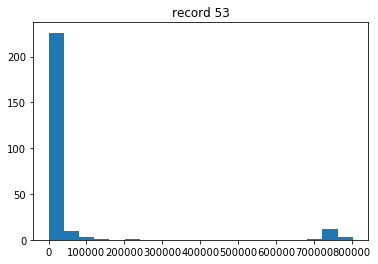

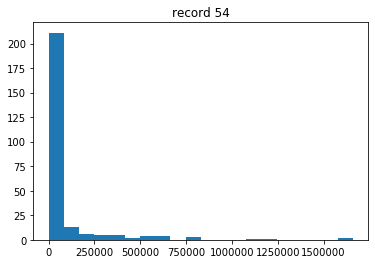

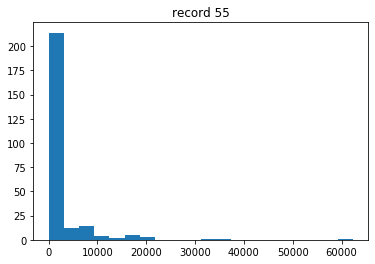

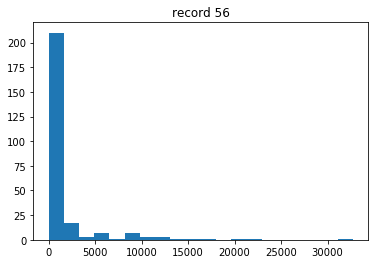

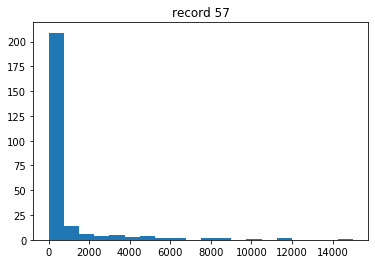

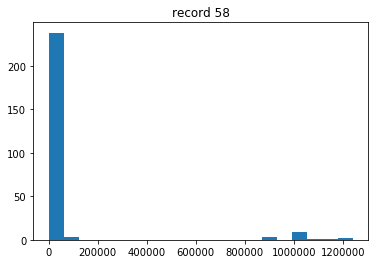

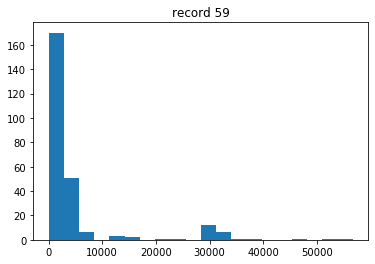

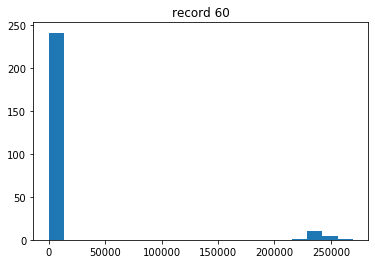

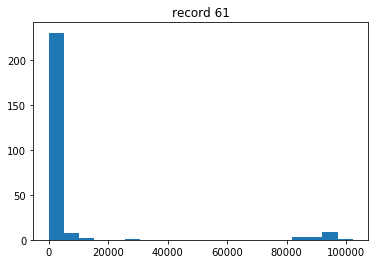

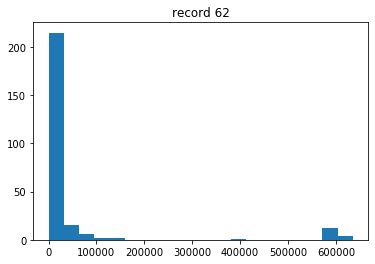

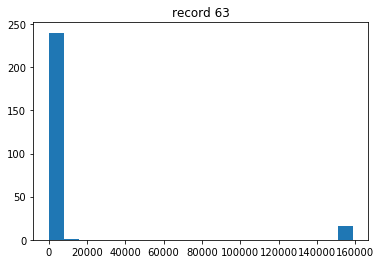

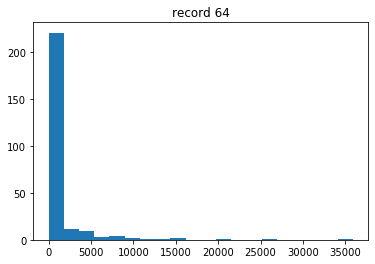

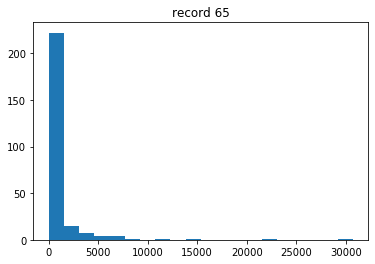

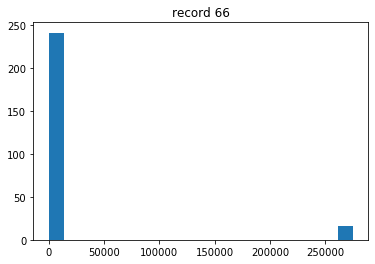

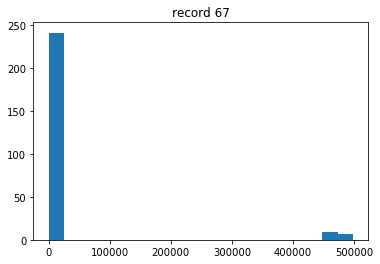

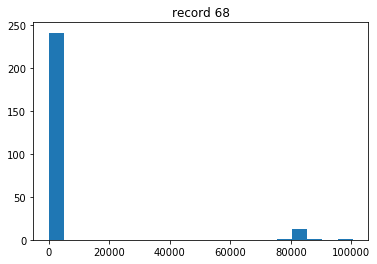

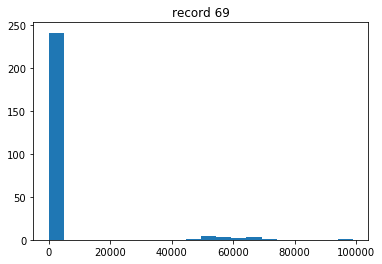

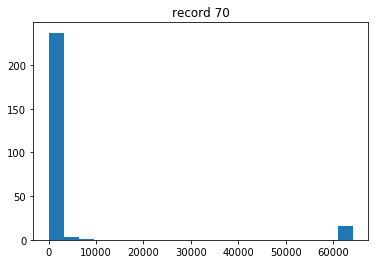

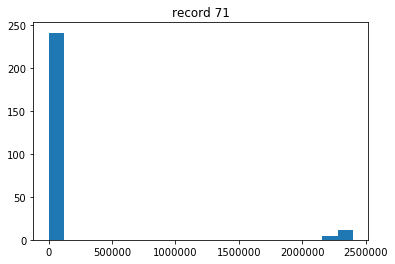

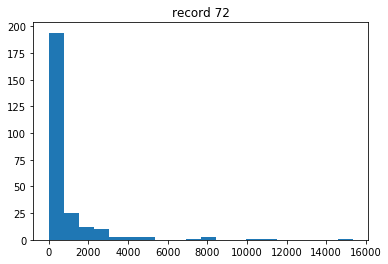

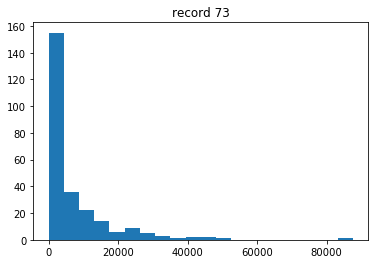

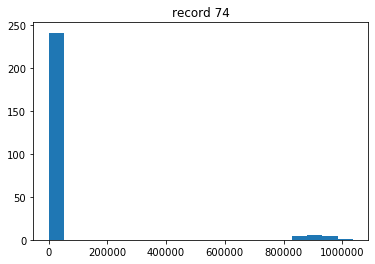

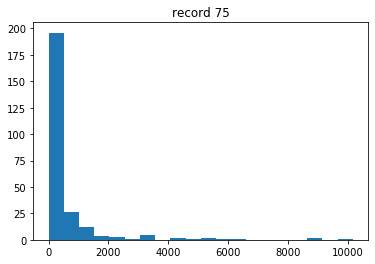

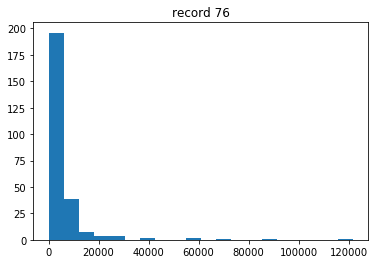

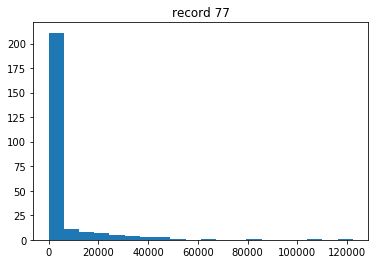

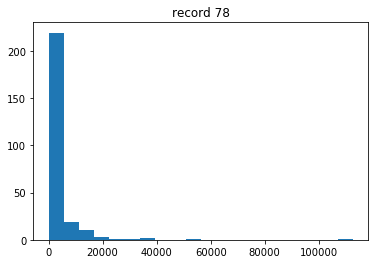

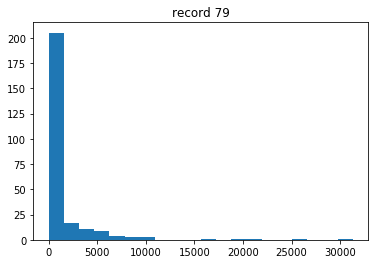

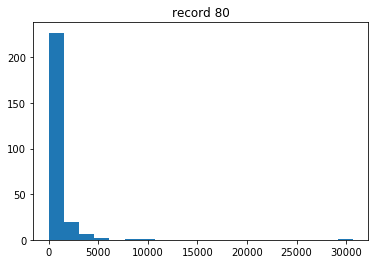

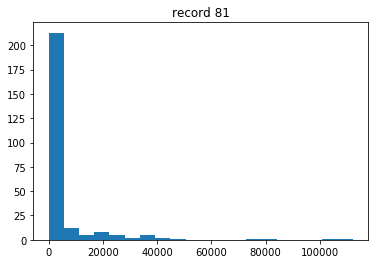

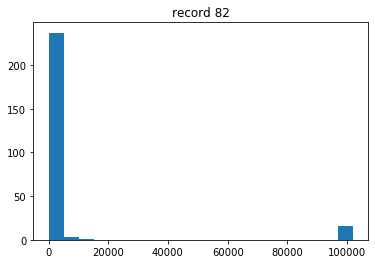

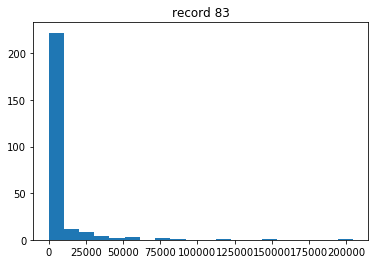

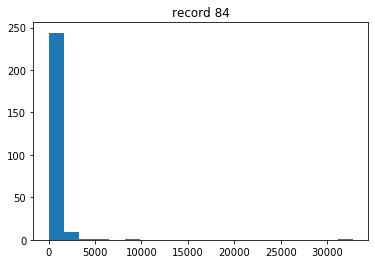

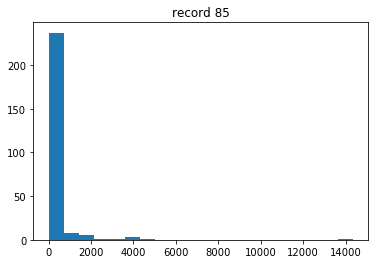

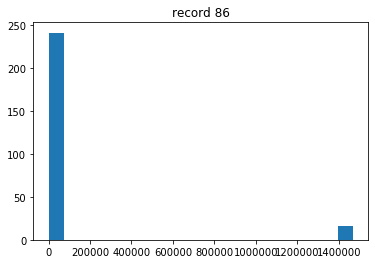

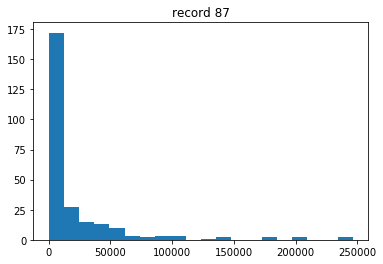

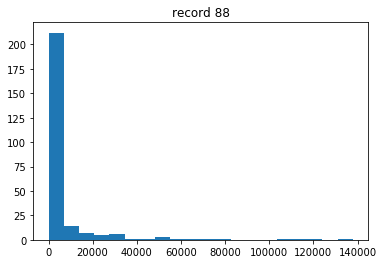

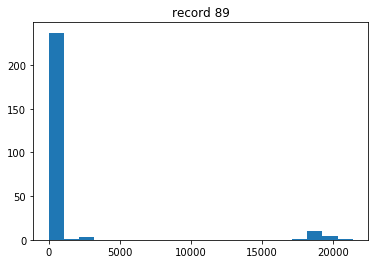

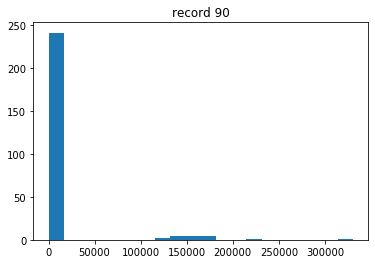

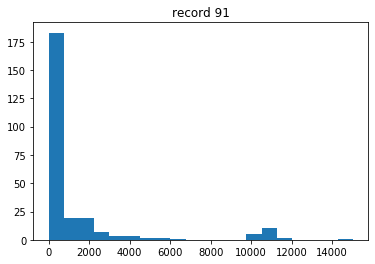

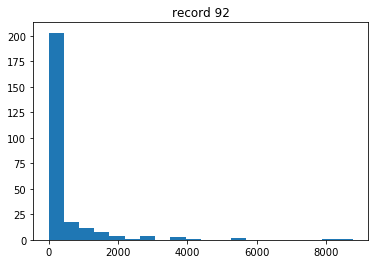

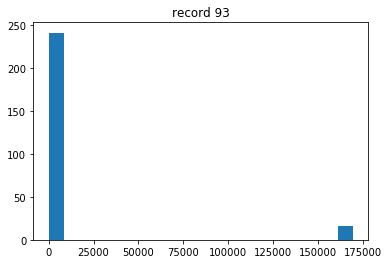

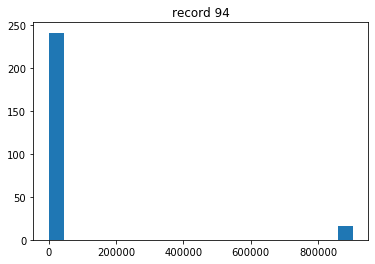

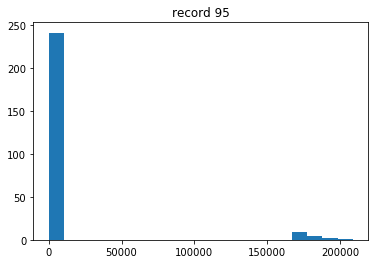

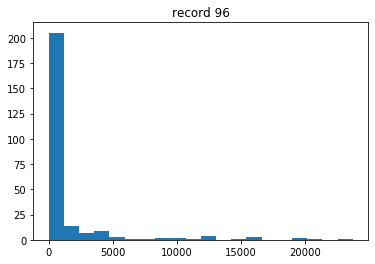

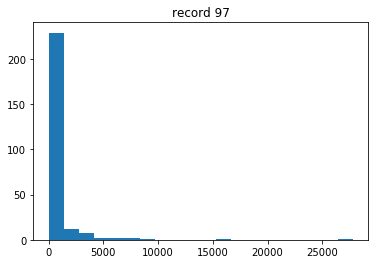

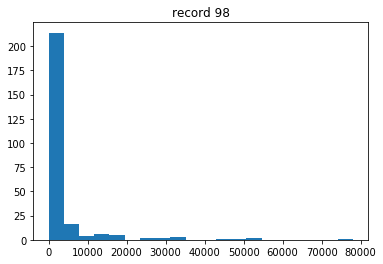

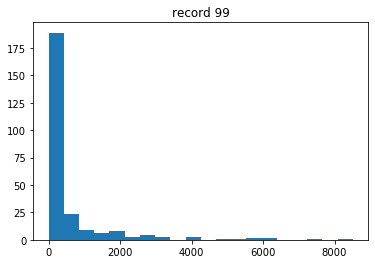

In [29]:
for i in range(100):
    plt.figure()
    plt.title("record " + str(i))
    plt.hist(byte_entropy.iloc[i,:], bins=20)

In [30]:
pd.options.display.float_format = "{:.2f}".format 
byte_entropy.describe()

,byteentropy_0,byteentropy_1,byteentropy_2,byteentropy_3,byteentropy_4,byteentropy_5,byteentropy_6,byteentropy_7,byteentropy_8,byteentropy_9,...,byteentropy_247,byteentropy_248,byteentropy_249,byteentropy_250,byteentropy_251,byteentropy_252,byteentropy_253,byteentropy_254,byteentropy_255,label
count,3204.00,3204.00,3204.00,3204.00,3204.00,3204.00,3204.00,3204.00,3204.00,3204.00,...,3204.00,3204.00,3204.00,3204.00,3204.00,3204.00,3204.00,3204.00,3204.00,3204.00
mean,94251.53,93.20,188.38,248.19,72.65,20.98,10.06,39.27,52.06,101.23,...,108807.36,110289.90,105700.40,107061.42,106896.06,107263.99,107216.83,108049.78,109744.84,0.35
std,1039959.85,2967.05,2784.00,11804.43,1349.97,482.95,168.51,1488.29,1709.48,2139.61,...,644305.36,637807.23,639005.48,638116.50,642717.13,638969.75,643150.78,644209.36,650909.78,0.48
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,203.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,957.00,834.00,944.50,792.00,1017.00,796.00,932.00,804.00,1006.00,0.00
75%,16384.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,31549.00,30370.50,30502.50,30752.00,30788.75,30329.00,30788.00,31492.25,30885.75,1.00
max,51245056.00,149975.00,60842.00,663983.00,54796.00,22512.00,6144.00,79787.00,75800.00,69619.00,...,22164690.00,21903135.00,22139041.00,22111489.00,22233847.00,22036329.00,22255884.00,22145333.00,22213691.00,1.00


In [31]:
byte_entropy_t = byte_entropy.T

In [32]:
byte_entropy_t

,0,1,2,3,4,5,6,7,8,9,...,3984,3985,3986,3988,3990,3991,3995,3997,3998,3999
byteentropy_0,0,47100,6144,0,0,0,0,12288,382564,0,...,0,20384,14332,14336,0,0,0,0,0,8127
byteentropy_1,0,2,0,0,0,0,0,0,101,0,...,0,30,0,0,0,0,0,0,0,2
byteentropy_2,0,0,0,0,0,0,0,0,29,0,...,0,8,0,0,0,0,0,0,0,1
byteentropy_3,0,0,0,0,0,0,0,0,18,0,...,0,4,2,0,0,0,0,0,0,2
byteentropy_4,0,0,0,0,0,0,0,0,23,0,...,0,6,2,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
byteentropy_252,372116,12835,0,289626,136392,203262,810102,0,10485,99733,...,0,8818,0,2742,20841,29728,0,0,267754,5797
byteentropy_253,373375,11881,0,289780,135605,205608,809875,0,10738,99417,...,0,9393,0,2625,20582,30391,0,0,268165,6404
byteentropy_254,373929,13610,0,291842,136067,207215,809533,0,10748,100092,...,0,8858,0,2193,20815,30100,0,0,267222,5691
byteentropy_255,375883,18303,0,291189,136331,214477,815054,0,10707,99894,...,0,9069,0,2226,21759,30351,0,0,267867,5760


In [33]:
describe = byte_entropy_t.describe()

In [34]:
type(describe)

pandas.core.frame.DataFrame

In [37]:
describe

,0,1,2,3,4,5,6,7,8,9,...,3984,3985,3986,3988,3990,3991,3995,3997,3998,3999
count,257.00,257.00,257.00,257.00,257.00,257.00,257.00,257.00,257.00,257.00,...,257.00,257.00,257.00,257.00,257.00,257.00,257.00,257.00,257.00,257.00
mean,24129.74,3912.72,1394.55,18495.75,8964.98,12774.10,50785.62,278.91,52793.77,6590.26,...,446.26,1267.05,1075.80,32218.15,1450.34,2135.66,262.97,757.04,17156.98,43884.58
std,89957.16,9139.01,2853.10,70281.12,32916.38,49157.17,196793.72,1050.63,179785.79,24094.18,...,2511.30,2843.79,3932.52,93943.80,5100.89,7289.11,1134.76,2128.56,64813.46,127182.74
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,12.00,2.00,10.00,0.00,0.00,0.00,0.00,0.00,561.00,0.00,...,0.00,0.00,0.00,32.00,0.00,0.00,0.00,0.00,0.00,622.00
50%,226.00,306.00,191.00,6.00,53.00,0.00,0.00,10.00,4742.00,0.00,...,0.00,24.00,13.00,4261.00,0.00,78.00,0.00,48.00,1.00,5760.00
75%,1285.00,2886.00,1493.00,348.00,362.00,144.00,198.00,98.00,27376.00,460.00,...,20.00,476.00,156.00,17904.00,168.00,211.00,48.00,378.00,417.00,32067.00
max,375883.00,86210.00,17588.00,292123.00,137426.00,214477.00,821520.00,12288.00,2286772.00,100635.00,...,34341.00,20384.00,32673.00,762771.00,24323.00,30765.00,10771.00,19814.00,270098.00,1337112.00


In [38]:
byte_entropy_t[0]['label']

0

In [39]:
byte_entropy_t[0].sum()

6201344

# Counting sum of entropy

In [40]:
# pierwsze podejscie
suma = {}
for i in byte_entropy_t:
       suma[i] =  byte_entropy_t[i].sum() ## tylko ze to liczy z labelem, ale to raczej nie ma wiekszego wplywu

In [42]:
byte_entropy

,byteentropy_0,byteentropy_1,byteentropy_2,byteentropy_3,byteentropy_4,byteentropy_5,byteentropy_6,byteentropy_7,byteentropy_8,byteentropy_9,...,byteentropy_247,byteentropy_248,byteentropy_249,byteentropy_250,byteentropy_251,byteentropy_252,byteentropy_253,byteentropy_254,byteentropy_255,label
0,0,0,0,0,0,0,0,0,0,0,...,375415,371989,372095,371755,373615,372116,373375,373929,375883,0
1,47100,2,0,0,0,0,2,0,0,0,...,12997,15116,14402,11916,12165,12835,11881,13610,18303,0
2,6144,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,291021,290256,289423,290909,291632,289626,289780,291842,291189,0
4,0,0,0,0,0,0,0,0,0,0,...,136028,135806,136048,137166,135946,136392,135605,136067,136331,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3991,0,0,0,0,0,0,0,0,0,0,...,30375,29937,30477,30189,29939,29728,30391,30100,30351,1
3995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3998,0,0,0,0,0,0,0,0,0,0,...,268844,268170,269384,267804,267861,267754,268165,267222,267867,1


In [43]:
suma_list = list(suma.values())

In [44]:
byte_entropy['suma'] = suma_list

In [45]:
byte_entropy

,byteentropy_0,byteentropy_1,byteentropy_2,byteentropy_3,byteentropy_4,byteentropy_5,byteentropy_6,byteentropy_7,byteentropy_8,byteentropy_9,...,byteentropy_248,byteentropy_249,byteentropy_250,byteentropy_251,byteentropy_252,byteentropy_253,byteentropy_254,byteentropy_255,label,suma
0,0,0,0,0,0,0,0,0,0,0,...,371989,372095,371755,373615,372116,373375,373929,375883,0,6201344
1,47100,2,0,0,0,0,2,0,0,0,...,15116,14402,11916,12165,12835,11881,13610,18303,0,1005568
2,6144,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,358400
3,0,0,0,0,0,0,0,0,0,0,...,290256,289423,290909,291632,289626,289780,291842,291189,0,4753408
4,0,0,0,0,0,0,0,0,0,0,...,135806,136048,137166,135946,136392,135605,136067,136331,0,2304000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3991,0,0,0,0,0,0,0,0,0,0,...,29937,30477,30189,29939,29728,30391,30100,30351,1,548865
3995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,67584
3997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,194560
3998,0,0,0,0,0,0,0,0,0,0,...,268170,269384,267804,267861,267754,268165,267222,267867,1,4409345


In [49]:
suma_list = list(suma.values())

(array([2.553e+03, 3.520e+02, 1.370e+02, 6.200e+01, 2.600e+01, 9.000e+00,
        1.100e+01, 3.000e+00, 8.000e+00, 7.000e+00, 7.000e+00, 2.000e+00,
        2.000e+00, 6.000e+00, 5.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

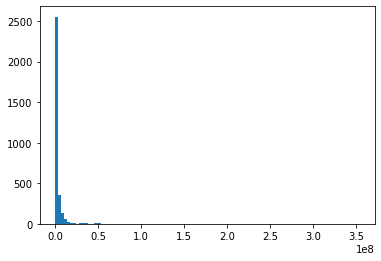

In [52]:
plt.hist(suma_list, bins=100)

In [55]:
suma_df = pd.DataFrame(suma_list)

In [56]:
#suma_df

In [57]:
suma_df['label'] = byte_entropy['label']

In [58]:
suma_df['label']

0      0.00
1      0.00
2      0.00
3      0.00
4      0.00
       ... 
3199   0.00
3200    nan
3201   1.00
3202   0.00
3203   1.00
Name: label, Length: 3204, dtype: float64

In [59]:
(suma_df['label']==0).sum() + (suma_df['label']==1).sum()

2635

po pierwsze skad ten nan wyzej
po drugie czemu te wymiary takie sa w sensie nizej 496 x 2 a nie x 1

## logistic regression

In [60]:
import sklearn
from sklearn.model_selection import train_test_split

In [61]:
X_train, X_test, y_train, y_test = train_test_split(byte_entropy['suma'], byte_entropy['label'], train_size=0.2, random_state=1)

In [62]:
from sklearn.linear_model import LogisticRegression

In [63]:
X_train.isna().sum(), y_train.isna().sum()

(0, 0)

In [64]:
X_train.isnull().sum(), y_train.isnull().sum()

(0, 0)

In [65]:
y_train1 = y_train.values.reshape(-1,1);
X_train1 = X_train.values.reshape(-1,1);

In [66]:
X_train1.shape, y_train1.shape

((640, 1), (640, 1))

In [67]:
clf = LogisticRegression(random_state=0).fit(X_train1, y_train1.ravel())

In [68]:
clf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [69]:
clf.coef_

array([[-7.77428604e-09]])

In [70]:
from sklearn.metrics import accuracy_score

In [71]:
X_test1 = X_test.values.reshape(-1,1);

In [72]:
y_predicted = clf.predict(X_test1)

In [73]:
accuracy_score(y_test, y_predicted)

0.6470358814352574

In [74]:
(y_test==y_predicted).sum()

1659

In [75]:
(y_test!=y_predicted).sum()

905

wyplotowac sume zalezna od labela

## plot

In [76]:
import seaborn as sns


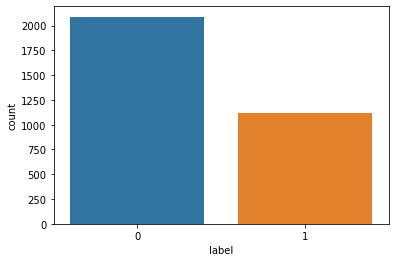

In [77]:
ax = sns.countplot(x=byte_entropy['label'], data=byte_entropy)

C:\Users\Marcin\Miniconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Marcin\Miniconda3\lib\site-packages\seaborn\categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


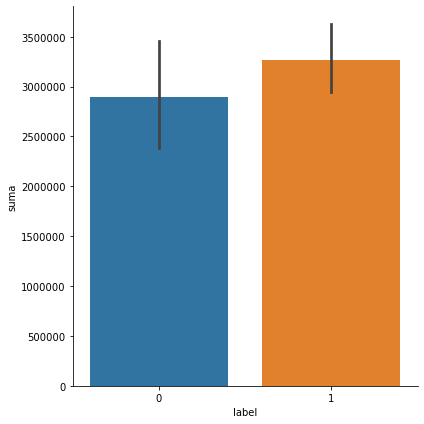

In [78]:
g = sns.factorplot(x = "label", y = "suma", data = byte_entropy, kind = "bar", size = 6)
g.set_ylabels("suma")
plt.show()

In [79]:
np.mean(byte_entropy['suma'][byte_entropy['label']==0])

2895445.4159885114

In [80]:
np.mean(byte_entropy['suma'][byte_entropy['label']==1])

3266103.6439461885

In [81]:
(byte_entropy['suma'][byte_entropy['label']==0]).describe()

count        2089.00
mean      2895445.42
std      12836102.46
min           642.00
25%         96256.00
50%        389120.00
75%       1632256.00
max     353595392.00
Name: suma, dtype: float64

In [82]:
(byte_entropy['suma'][byte_entropy['label']==1]).describe()

count        1115.00
mean      3266103.64
std       5976181.82
min          6145.00
25%        425985.00
50%       1955841.00
75%       4420609.00
max     142802945.00
Name: suma, dtype: float64

as we can see sum of byteentropy is generally higher for data with label 1 

In [83]:
# plotowac moze scatter, zeby zera byly niebieskie, jedynki czerwone

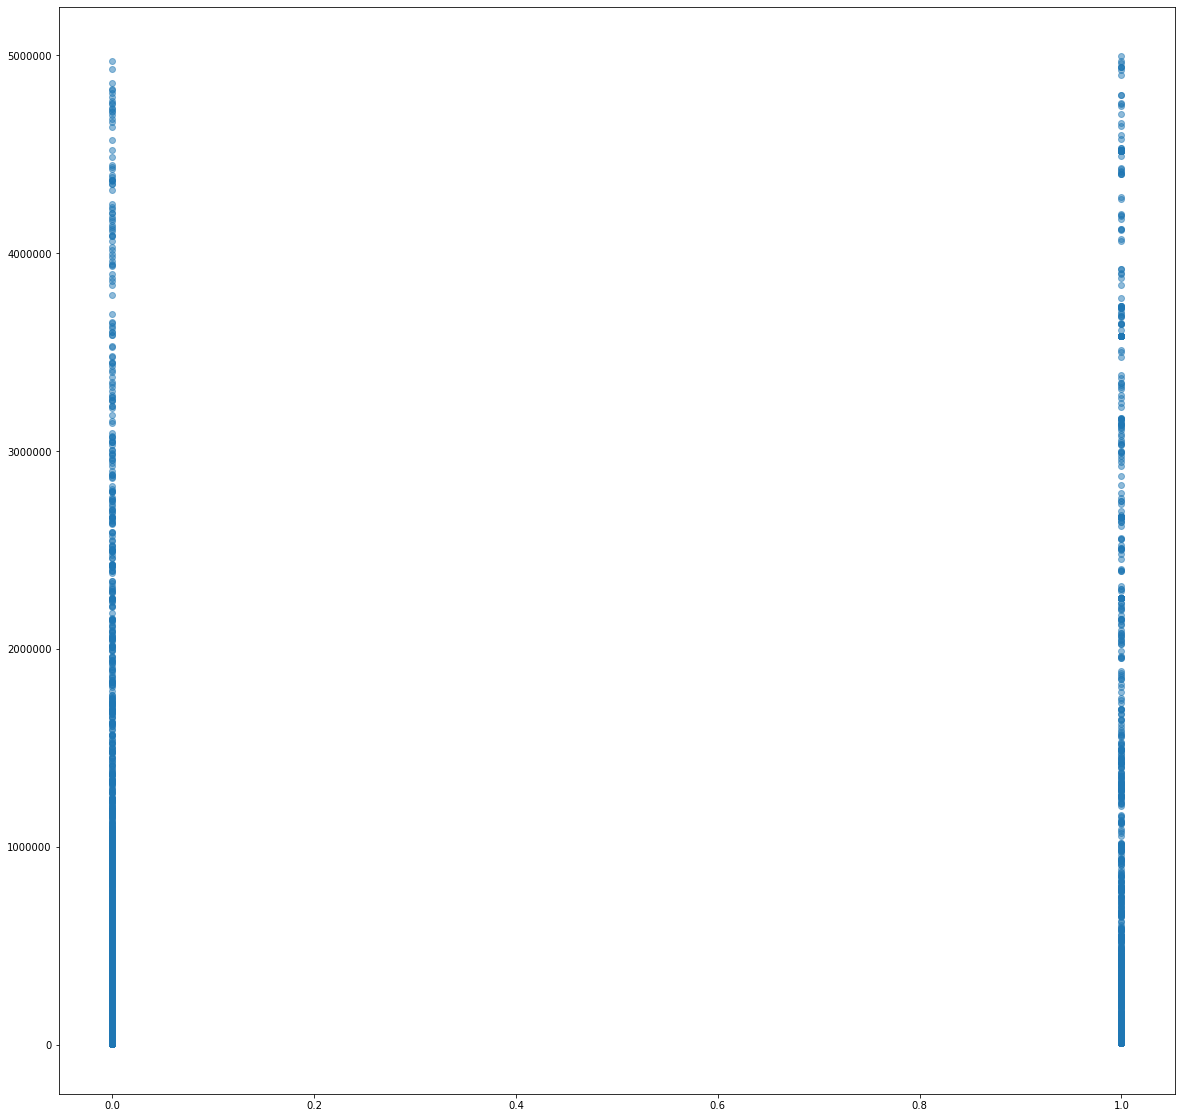

In [140]:
plt.figure(figsize = (20,20))
#plt.scatter(byte_entropy['label'], byte_entropy['suma'], alpha=0.5)
plt.scatter(byte_entropy['label'][byte_entropy['suma']< 5000000], byte_entropy['suma'][byte_entropy['suma']< 5000000], alpha=0.5)

fajnie by było sprawdzić jaki będzie wynik jak podamy dane takie, ze suma entropii nie bedzie przekraczala 0.3e10

# Correlation

In [85]:
byte_entropy.iloc[:,:10]

,byteentropy_0,byteentropy_1,byteentropy_2,byteentropy_3,byteentropy_4,byteentropy_5,byteentropy_6,byteentropy_7,byteentropy_8,byteentropy_9
0,0,0,0,0,0,0,0,0,0,0
1,47100,2,0,0,0,0,2,0,0,0
2,6144,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
3991,0,0,0,0,0,0,0,0,0,0
3995,0,0,0,0,0,0,0,0,0,0
3997,0,0,0,0,0,0,0,0,0,0
3998,0,0,0,0,0,0,0,0,0,0


In [86]:
corrmat = byte_entropy.corr() 

In [87]:
corrmat

,byteentropy_0,byteentropy_1,byteentropy_2,byteentropy_3,byteentropy_4,byteentropy_5,byteentropy_6,byteentropy_7,byteentropy_8,byteentropy_9,...,byteentropy_248,byteentropy_249,byteentropy_250,byteentropy_251,byteentropy_252,byteentropy_253,byteentropy_254,byteentropy_255,label,suma
byteentropy_0,1.00,0.04,0.02,-0.00,-0.00,0.00,0.00,0.06,0.00,0.03,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.11
byteentropy_1,0.04,1.00,0.10,0.00,0.01,0.02,0.00,-0.00,0.00,-0.00,...,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.02,0.05
byteentropy_2,0.02,0.10,1.00,-0.00,0.16,0.00,0.00,-0.00,-0.00,-0.00,...,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.02,0.03
byteentropy_3,-0.00,0.00,-0.00,1.00,0.00,0.00,0.02,0.00,0.00,0.00,...,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.01,-0.00
byteentropy_4,-0.00,0.01,0.16,0.00,1.00,0.00,0.03,-0.00,0.00,0.09,...,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
byteentropy_253,0.00,-0.00,-0.00,-0.00,-0.00,-0.01,0.00,-0.00,0.00,-0.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.00,0.95
byteentropy_254,0.00,-0.00,-0.00,-0.00,-0.00,-0.01,0.00,-0.00,0.00,-0.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.00,0.95
byteentropy_255,0.00,-0.00,0.00,-0.00,-0.00,-0.01,0.00,-0.00,0.00,-0.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.00,0.95
label,0.08,-0.02,0.02,-0.01,-0.01,0.00,-0.00,-0.02,-0.02,0.05,...,0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,1.00,0.02


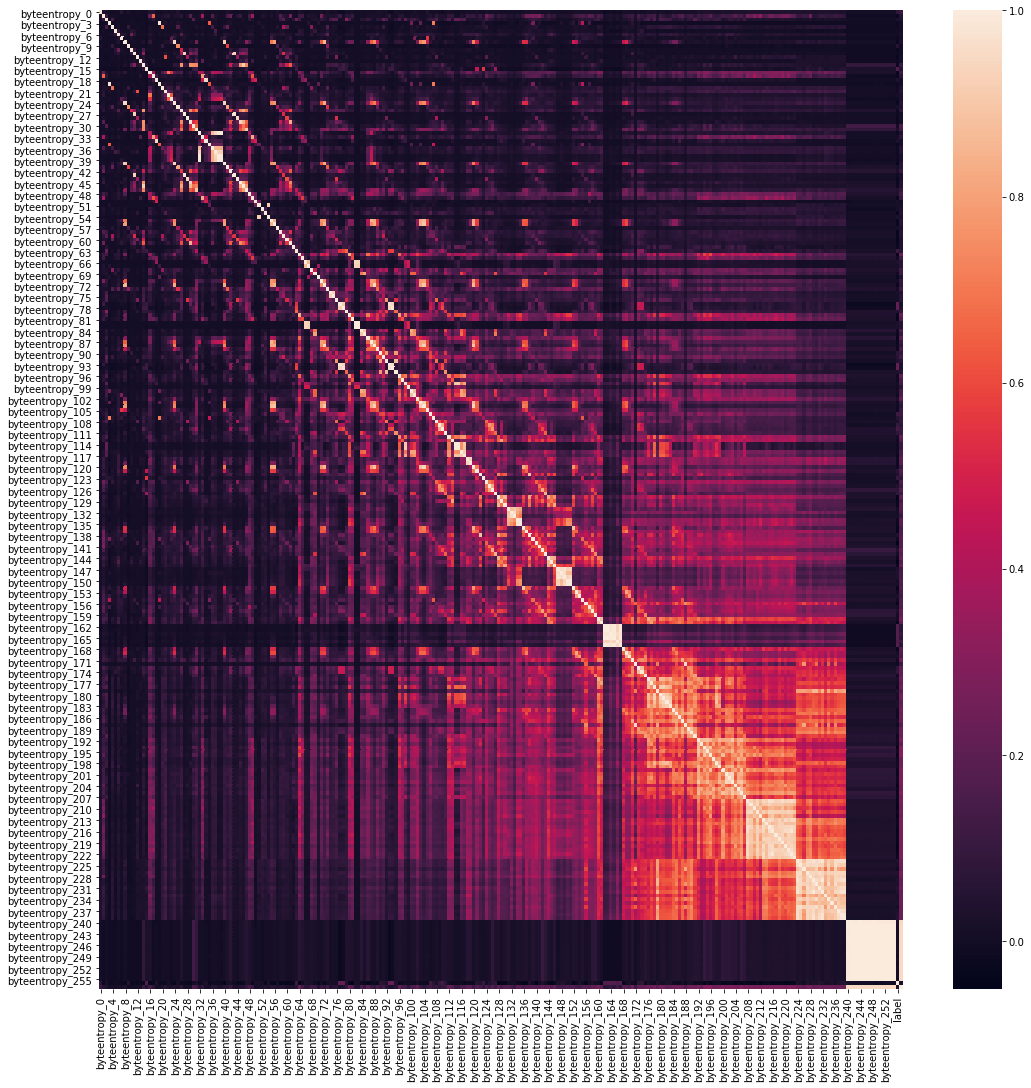

In [88]:
fig, ax = plt.subplots()
fig.set_size_inches(18,18)
sns.heatmap(corrmat)

In [89]:
byte_entropy.iloc[:1,:]

,byteentropy_0,byteentropy_1,byteentropy_2,byteentropy_3,byteentropy_4,byteentropy_5,byteentropy_6,byteentropy_7,byteentropy_8,byteentropy_9,...,byteentropy_248,byteentropy_249,byteentropy_250,byteentropy_251,byteentropy_252,byteentropy_253,byteentropy_254,byteentropy_255,label,suma
0,0,0,0,0,0,0,0,0,0,0,...,371989,372095,371755,373615,372116,373375,373929,375883,0,6201344


corr dla ostatnich byteentropy

In [90]:
corrmat = byte_entropy.iloc[:,200:].corr() 

In [91]:
corrmat

,byteentropy_200,byteentropy_201,byteentropy_202,byteentropy_203,byteentropy_204,byteentropy_205,byteentropy_206,byteentropy_207,byteentropy_208,byteentropy_209,...,byteentropy_248,byteentropy_249,byteentropy_250,byteentropy_251,byteentropy_252,byteentropy_253,byteentropy_254,byteentropy_255,label,suma
byteentropy_200,1.00,0.75,0.67,0.79,0.81,0.70,0.88,0.66,0.81,0.72,...,0.07,0.08,0.07,0.08,0.07,0.07,0.08,0.08,-0.03,0.30
byteentropy_201,0.75,1.00,0.93,0.94,0.66,0.82,0.84,0.73,0.63,0.59,...,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,-0.03,0.28
byteentropy_202,0.67,0.93,1.00,0.92,0.63,0.83,0.79,0.69,0.57,0.55,...,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,-0.02,0.27
byteentropy_203,0.79,0.94,0.92,1.00,0.72,0.88,0.89,0.80,0.70,0.65,...,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,-0.02,0.29
byteentropy_204,0.81,0.66,0.63,0.72,1.00,0.73,0.83,0.64,0.76,0.70,...,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,-0.05,0.27
byteentropy_205,0.70,0.82,0.83,0.88,0.73,1.00,0.89,0.79,0.69,0.65,...,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,-0.02,0.26
byteentropy_206,0.88,0.84,0.79,0.89,0.83,0.89,1.00,0.80,0.79,0.72,...,0.08,0.09,0.09,0.09,0.09,0.09,0.09,0.09,-0.03,0.32
byteentropy_207,0.66,0.73,0.69,0.80,0.64,0.79,0.80,1.00,0.57,0.54,...,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,-0.02,0.26
byteentropy_208,0.81,0.63,0.57,0.70,0.76,0.69,0.79,0.57,1.00,0.94,...,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,-0.03,0.28
byteentropy_209,0.72,0.59,0.55,0.65,0.70,0.65,0.72,0.54,0.94,1.00,...,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,-0.04,0.27


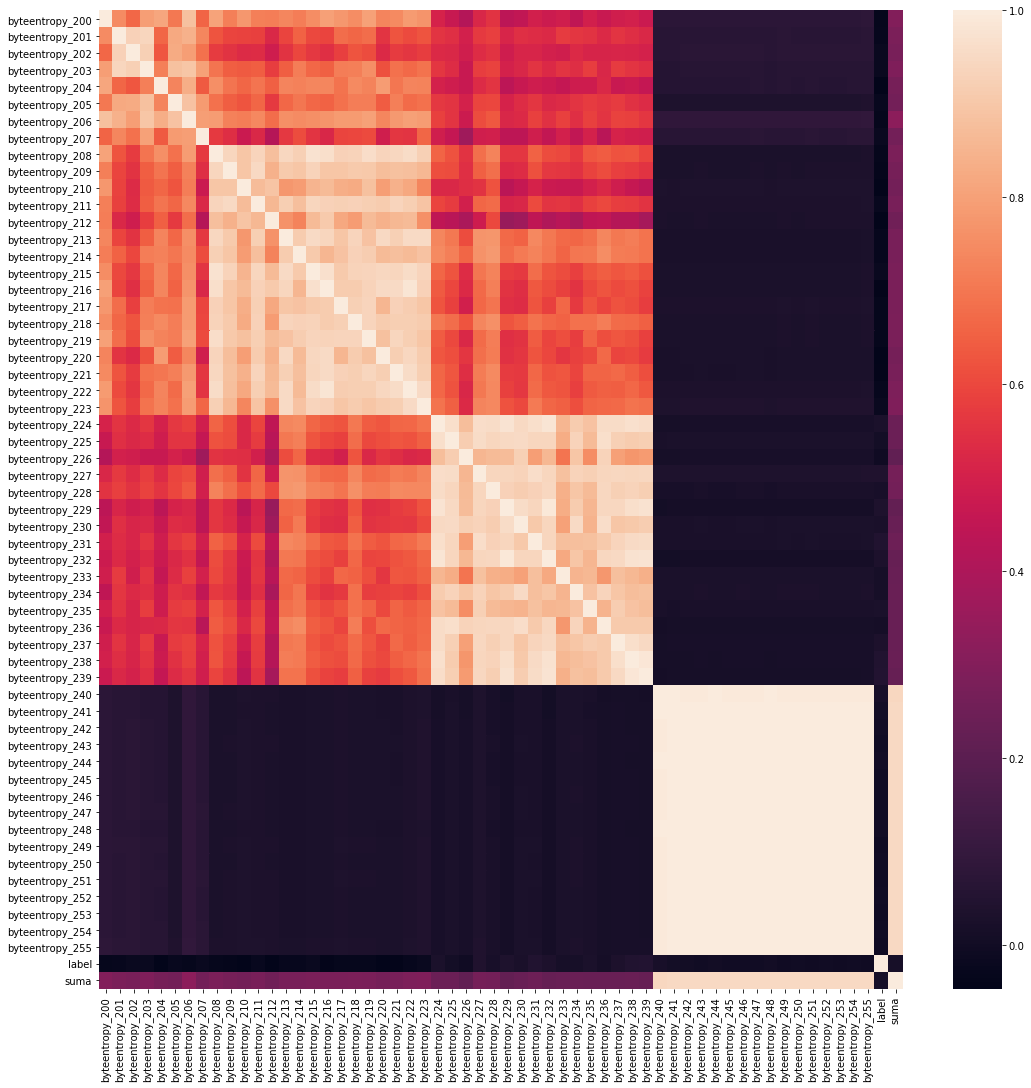

In [92]:
fig, ax = plt.subplots()
fig.set_size_inches(18,18)
sns.heatmap(corrmat)

as we can see we have high correlation between entropy for data between byte 240 and 255

### correlation between label and sum of all byteentropy

In [98]:
byte_entropy['label'].astype('float64').corr(byte_entropy['suma'])

0.016129304504445708

# logistic regression for entropy of last bytes

In [99]:
X_train_last_be, X_test_last_be, y_train_last_be, y_test_last_be = train_test_split(byte_entropy.iloc[:,257:258], byte_entropy.iloc[:,256:257], train_size=0.5, random_state=1)

In [100]:
byte_entropy.iloc[:3,256:257]

,label
0,0
1,0
2,0


In [101]:
y_train_last_be1 = y_train_last_be.values.reshape(-1,1);
X_train_last_be1 = X_train_last_be.values.reshape(-1,1);

In [102]:
clf_last_be = LogisticRegression(random_state=0).fit(X_train_last_be1, y_train_last_be1.ravel())

In [103]:
X_test_last_be1 = X_test_last_be.values.reshape(-1,1);

In [104]:
y_predicted_last_be = clf.predict(X_test_last_be1)

In [105]:
accuracy_score(y_test_last_be, y_predicted_last_be)

0.632334581772784

# correlation with other entropy columns

In [106]:
entropy_columns = [col for col in df.columns if 'entropy' in col]

In [107]:
entropy_columns

['byteentropy_0',
 'byteentropy_1',
 'byteentropy_2',
 'byteentropy_3',
 'byteentropy_4',
 'byteentropy_5',
 'byteentropy_6',
 'byteentropy_7',
 'byteentropy_8',
 'byteentropy_9',
 'byteentropy_10',
 'byteentropy_11',
 'byteentropy_12',
 'byteentropy_13',
 'byteentropy_14',
 'byteentropy_15',
 'byteentropy_16',
 'byteentropy_17',
 'byteentropy_18',
 'byteentropy_19',
 'byteentropy_20',
 'byteentropy_21',
 'byteentropy_22',
 'byteentropy_23',
 'byteentropy_24',
 'byteentropy_25',
 'byteentropy_26',
 'byteentropy_27',
 'byteentropy_28',
 'byteentropy_29',
 'byteentropy_30',
 'byteentropy_31',
 'byteentropy_32',
 'byteentropy_33',
 'byteentropy_34',
 'byteentropy_35',
 'byteentropy_36',
 'byteentropy_37',
 'byteentropy_38',
 'byteentropy_39',
 'byteentropy_40',
 'byteentropy_41',
 'byteentropy_42',
 'byteentropy_43',
 'byteentropy_44',
 'byteentropy_45',
 'byteentropy_46',
 'byteentropy_47',
 'byteentropy_48',
 'byteentropy_49',
 'byteentropy_50',
 'byteentropy_51',
 'byteentropy_52',
 'b

In [113]:
strings_entropy = df['strings_entropy']

In [114]:
byte_entropy['suma']

0        6201344
1        1005568
2         358400
3        4753408
4        2304000
          ...   
3991      548865
3995       67584
3997      194560
3998     4409345
3999    11278337
Name: suma, Length: 3204, dtype: int64

In [115]:

#entropy_corr = byte_entropy['suma']
#entropy_corr['strings'] = strings_entropy

In [116]:
#entropy_corr.shape, byte_entropy['suma'].shape

In [117]:
column_names = ["strings", "suma"]

to_corr = pd.DataFrame(columns = column_names)
to_corr['strings'] = strings_entropy

to_corr['suma'] = byte_entropy['suma']

In [118]:
to_corr

,strings,suma
0,6.57,6201344.00
1,5.80,1005568.00
2,5.74,358400.00
3,6.58,4753408.00
4,6.56,2304000.00
...,...,...
3995,5.10,67584.00
3996,5.71,nan
3997,5.15,194560.00
3998,6.56,4409345.00


In [119]:
#corrmat = to_corr.corr() 

In [120]:
#corrmat

In [121]:
to_corr['suma'].astype('float64').corr(to_corr['strings'])

0.18225515438837478

In [122]:
type(to_corr['suma']), type(to_corr['suma'])

(pandas.core.series.Series, pandas.core.series.Series)

# subsampling

subsampling is conducted to make sure there is equal number of data with label 0 and data with label 1 in our model

In [123]:
import sklearn
from imblearn.under_sampling import RandomUnderSampler
import imblearn; imblearn.show_versions(github=True)
rus = RandomUnderSampler()
#X_rus, y_rus= rus.fit_sample(data_directories.drop(data_directories['label']), data_directories['label'])
X_rus, y_rus= rus.fit_sample(byte_entropy.drop(['label'], axis=1), byte_entropy['label'])

<details><summary>System, Dependency Information</summary>

**System Information**

* python    : `3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]`
* executable: `C:\Users\Marcin\Miniconda3\python.exe`
* machine   : `Windows-10-10.0.19041-SP0`

**Python Dependencies**

* pip       : `20.3.3`
* setuptools: `52.0.0.post20210125`
* imblearn  : `0.7.0`
* sklearn   : `0.23.2`
* numpy     : `1.18.1`
* scipy     : `1.6.0`
* Cython    : `None`
* pandas    : `1.0.1`
* keras     : `None`
* tensorflow: `None`
* joblib    : `1.0.0`

</details>


In [124]:
#byte_entropy.drop(['label'], axis=1)

In [125]:
X_rus.shape, y_rus.shape

((2230, 257), (2230,))

In [126]:
(y_rus == 0).sum(), (y_rus == 1).sum()

(1115, 1115)

## logistic regression for all columns (every byteentropy)

In [127]:
dicts = {}
for col in X_rus:
    X_train, X_test, y_train, y_test = train_test_split(X_rus[col], y_rus, train_size=0.5)
    y_train1 = y_train.values.reshape(-1,1);
    X_train1 = X_train.values.reshape(-1,1);

    clf = LogisticRegression(random_state=0).fit(X_train1, y_train1.ravel())

    X_test1 = X_test.values.reshape(-1,1);

    y_predicted = clf.predict(X_test1)

    dicts[col] = accuracy_score(y_test, y_predicted)
    #scores.append(accuracy_score(y_test, y_predicted))

In [128]:
dicts

{'byteentropy_0': 0.4977578475336323,
 'byteentropy_1': 0.4914798206278027,
 'byteentropy_2': 0.46905829596412557,
 'byteentropy_3': 0.49865470852017935,
 'byteentropy_4': 0.4968609865470852,
 'byteentropy_5': 0.48251121076233183,
 'byteentropy_6': 0.48878923766816146,
 'byteentropy_7': 0.4968609865470852,
 'byteentropy_8': 0.49327354260089684,
 'byteentropy_9': 0.48699551569506727,
 'byteentropy_10': 0.46816143497757845,
 'byteentropy_11': 0.49506726457399103,
 'byteentropy_12': 0.4923766816143498,
 'byteentropy_13': 0.48071748878923765,
 'byteentropy_14': 0.4977578475336323,
 'byteentropy_15': 0.5201793721973094,
 'byteentropy_16': 0.48161434977578477,
 'byteentropy_17': 0.5031390134529148,
 'byteentropy_18': 0.4834080717488789,
 'byteentropy_19': 0.4905829596412556,
 'byteentropy_20': 0.49865470852017935,
 'byteentropy_21': 0.49865470852017935,
 'byteentropy_22': 0.4914798206278027,
 'byteentropy_23': 0.4959641255605381,
 'byteentropy_24': 0.48699551569506727,
 'byteentropy_25': 0.4

In [129]:
{k: v for k, v in sorted(dicts.items(), key=lambda item: item[1])}

{'byteentropy_247': 0.2914798206278027,
 'byteentropy_245': 0.2968609865470852,
 'byteentropy_195': 0.42152466367713004,
 'byteentropy_196': 0.42869955156950673,
 'byteentropy_207': 0.4295964125560538,
 'byteentropy_194': 0.43318385650224217,
 'byteentropy_199': 0.43766816143497755,
 'byteentropy_188': 0.4412556053811659,
 'byteentropy_221': 0.4430493273542601,
 'byteentropy_197': 0.4493273542600897,
 'byteentropy_200': 0.4493273542600897,
 'byteentropy_212': 0.45201793721973094,
 'byteentropy_218': 0.452914798206278,
 'byteentropy_222': 0.4538116591928251,
 'byteentropy_208': 0.45829596412556056,
 'byteentropy_217': 0.45829596412556056,
 'byteentropy_219': 0.45829596412556056,
 'byteentropy_223': 0.4609865470852018,
 'byteentropy_211': 0.4618834080717489,
 'byteentropy_216': 0.4618834080717489,
 'byteentropy_29': 0.46278026905829595,
 'byteentropy_69': 0.46367713004484307,
 'byteentropy_210': 0.46367713004484307,
 'byteentropy_10': 0.46816143497757845,
 'byteentropy_2': 0.469058295964

In [130]:
best_columns = X_rus[['byteentropy_246', 'byteentropy_250']]

In [131]:
best_columns.shape

(2230, 2)

## logistic regression for columns with best accuracy in single variable logistic regression

In [132]:
X_train, X_test, y_train, y_test = train_test_split(best_columns, y_rus, train_size=0.5)
#y_train1 = y_train.values.reshape(-1,1);
#X_train1 = X_train.values.reshape(-1,1);

X_train.shape, X_test.shape, y_train.shape, y_test.shape
clf = LogisticRegression(random_state=0).fit(X_train, y_train.ravel())

#X_test1 = X_test.values.reshape(-1,1);

y_predicted = clf.predict(X_test)

accuracy_score(y_test, y_predicted)

0.4125560538116592

accuracy score above varies from 0.37 to 0.61 so it sholud be checked when we have all dataset available

## decision tree for columns with best accuracy in single variable logistic regression

In [133]:
from sklearn import tree
clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(best_columns, y_rus)
prediction = clf_tree.predict(X_test)
accuracy_score(y_test, prediction)

0.947085201793722

score above is too high there must be something wrong

In [134]:
y_test.sum()

537

In [135]:
prediction.sum()

478

In [136]:
clf_tree.feature_importances_ 

array([0.34466147, 0.65533853])

## decision tree for each column

In [137]:
dicts_tree = {}
for col in X_rus:
    X_train, X_test, y_train, y_test = train_test_split(X_rus[col], y_rus, train_size=0.5)
    y_train1 = y_train.values.reshape(-1,1);
    X_train1 = X_train.values.reshape(-1,1);
    
    clf_tree = tree.DecisionTreeClassifier()
    clf_tree = clf_tree.fit(X_train1, y_train1)

    X_test1 = X_test.values.reshape(-1,1);

    y_predicted = clf_tree.predict(X_test1)

    dicts_tree[col] = accuracy_score(y_test, y_predicted)
    #scores.append(accuracy_score(y_test, y_predicted))

In [138]:
{k: v for k, v in sorted(dicts_tree.items(), key=lambda item: item[1])}

{'byteentropy_8': 0.4977578475336323,
 'byteentropy_13': 0.5031390134529148,
 'byteentropy_7': 0.5130044843049327,
 'byteentropy_36': 0.5165919282511211,
 'byteentropy_67': 0.5192825112107623,
 'byteentropy_90': 0.5192825112107623,
 'byteentropy_2': 0.5201793721973094,
 'byteentropy_11': 0.5201793721973094,
 'byteentropy_30': 0.5219730941704036,
 'byteentropy_31': 0.5219730941704036,
 'byteentropy_1': 0.5228699551569507,
 'byteentropy_22': 0.5228699551569507,
 'byteentropy_51': 0.5237668161434977,
 'byteentropy_76': 0.5246636771300448,
 'byteentropy_4': 0.525560538116592,
 'byteentropy_3': 0.526457399103139,
 'byteentropy_20': 0.526457399103139,
 'byteentropy_9': 0.5282511210762332,
 'byteentropy_23': 0.5282511210762332,
 'byteentropy_5': 0.5300448430493273,
 'byteentropy_43': 0.5300448430493273,
 'byteentropy_34': 0.5309417040358745,
 'byteentropy_39': 0.5309417040358745,
 'byteentropy_17': 0.5318385650224215,
 'byteentropy_26': 0.5318385650224215,
 'byteentropy_40': 0.531838565022421

calculate distribution of entropy for each record